<a href="https://colab.research.google.com/github/carloscotrini/transformers_from_scratch/blob/main/AML_MyDiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random

SHAPES = ["triangle", "circle"]
PLURALS = [shape + "s" for shape in SHAPES]
ARTICLES = ["a", "one"]
TWO_ARTICLES = ["two"]
CONNECTORS = ["and", "then"]
REVERSE_CONNECTORS = ["after"]
CLASS_TOKEN = "CLS"
MASK_TOKEN = "MASK"
SEP_TOKEN = "SEP"
PAD_TOKEN = "PAD"
EOS_TOKEN = "EOS"
SPECIAL_TOKENS = [CLASS_TOKEN, MASK_TOKEN, SEP_TOKEN, PAD_TOKEN, EOS_TOKEN]
VOCABULARY = SHAPES + PLURALS + ARTICLES + CONNECTORS + REVERSE_CONNECTORS + TWO_ARTICLES + SPECIAL_TOKENS
MAX_LEN_SENTENCE = 16 # Maximum possible length of a sequence

def generate_random_shapes():
  num_shapes = random.randint(1, 4)
  result = []
  for _ in range(num_shapes):
    result.append(random.choice(SHAPES))
  return result

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

def generate_image(word_list, filename, mask_filename):
    # Create a blank 32x32 image
    image_size = 32
    patch_size = 16
    image = Image.new("1", (image_size, image_size), 1)  # '1' for 1-bit pixels, black and white
    mask = Image.new("1", (image_size, image_size), 1)

    for i, word in enumerate(word_list):
        if word not in ["triangle", "circle"]:
            continue

        # Determine the top-left corner of the patch
        x_offset = (i % 2) * patch_size
        y_offset = (i // 2) * patch_size

        # Draw the shape in the corresponding patch
        draw = ImageDraw.Draw(image)
        draw_mask = ImageDraw.Draw(mask)
        if word == "triangle":
            points = [(random.randint(x_offset, x_offset + patch_size), random.randint(y_offset, y_offset + patch_size)) for _ in range(3)]
            draw.polygon(points, fill=0)
            draw_mask.polygon(points, fill=0)
        elif word == "circle":
            radius = random.randint(2, patch_size // 2)
            center_x = random.randint(x_offset + radius, x_offset + patch_size - radius)
            center_y = random.randint(y_offset + radius, y_offset + patch_size - radius)
            draw.ellipse([center_x - radius, center_y - radius, center_x + radius, center_y + radius], fill=0)

    # Save the image to the specified filename
    image.save(filename)
    mask.save(mask_filename)

def plot_image(filename):
    # Open the image
    image = Image.open(filename)

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example usage:
generate_image(["circle", "triangle", "circle"], "output_image.png", "masked_output_image.png")

In [ ]:
def generate_data(n_samples):
  examples = []
  for i in range(n_samples):
    shape_list = generate_random_shapes()
    filename = f"f{i}.png"
    mask_filename = f"m{i}.png"
    generate_image(shape_list, filename, mask_filename)
    examples.append({"shape_list": shape_list, "filename": filename, "mask_filename": mask_filename})
  return examples

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [ ]:
class FigureDataset(Dataset):
    def __init__(self, n_samples, image_dir=".", transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.examples = generate_data(n_samples)
        self.image_files = [e["filename"] for e in self.examples]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('L')

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
import math

class MyPositionalEncoding():
    def __init__(self, d_model, T):
        super(MyPositionalEncoding, self).__init__()

        # Create a matrix of shape (max_len, d_model) with all zeros
        self.pe = torch.zeros(T + 1, d_model)

        # Create a column vector of shape (max_len, 1) with values [0, 1, ..., max_len-1]
        position = torch.arange(0, T + 1, dtype=torch.float).unsqueeze(1)

        # Create a row vector of shape (1, d_model // 2) with values [0, 1, ..., d_model//2-1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices and cosine to odd indices
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)

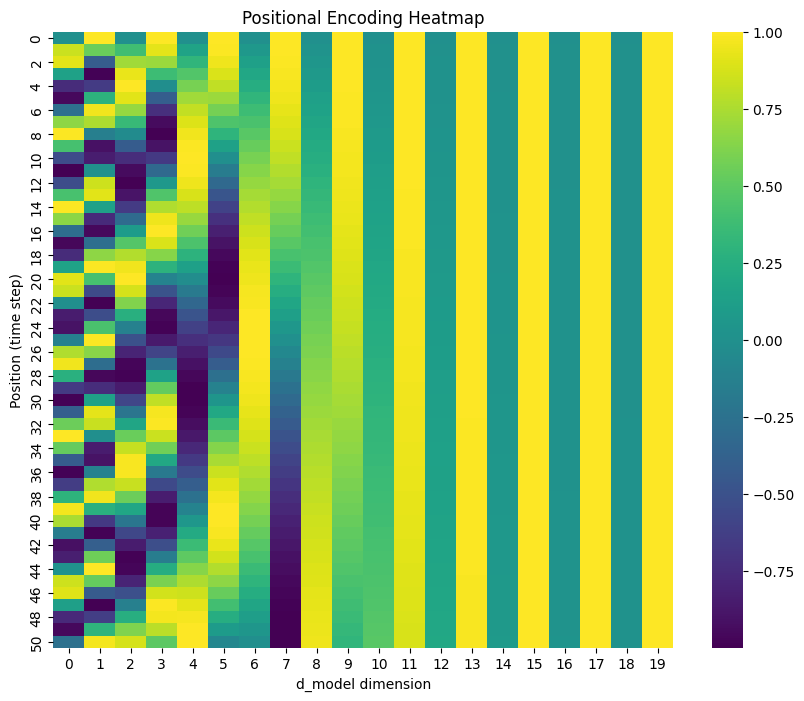

In [ ]:
import seaborn as sns

# Instantiate the class with example parameters
d_model = 20  # Dimensionality of the model
T = 50        # Maximum time or sequence length
pos_encoding = MyPositionalEncoding(d_model, T)

# Convert the positional encoding tensor to a NumPy array
pe_matrix = pos_encoding.pe.numpy()

# Plot the heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(pe_matrix, cmap='viridis', cbar=True)
plt.title("Positional Encoding Heatmap")
plt.xlabel("d_model dimension")
plt.ylabel("Position (time step)")
plt.show()

In [ ]:
class DiffusionModel():

  def __init__(self, T, model: nn.Module):
    self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
    self.alphas = 1 - self.betas
    self.alphas_bar = torch.cumprod(self.alphas, 0)

    self.T = T
    self.model = model

  def forward_process(self, x0, t):
    """
    :param t: Number of diffusion steps
    """

    t = t - 1 # Because we start indexing at 0

    factors = self.alphas_bar[t].view(self.alphas_bar[t].shape[0], 1, 1, 1)
    mu = torch.sqrt(factors) * x0
    std = torch.sqrt(1 - factors)
    epsilon = torch.randn_like(x0)

    return mu + epsilon * std # data ~ N(mu, std)

  def reverse_process(self, xt, t):
    """
    :param t: Number of diffusion steps
    """

    t = t - 1 # Because we start indexing at 0

    z = torch.randn_like(xt)

    std = torch.sqrt(self.betas[t]).view(self.betas[t].shape[0], 1, 1, 1)

    pred_eps = self.model(xt, t)

    alphas = self.alphas[t].view(self.alphas[t].shape[0], 1, 1, 1)
    alphas_bar = self.alphas_bar[t].view(self.alphas_bar[t].shape[0], 1, 1, 1)

    a = (1 / torch.sqrt(alphas))
    b = (xt - (1 - alphas) / torch.sqrt(1 - alphas_bar) * pred_eps)
    c = std * z
    xt_1 = a * b + c

    return xt_1

  def sample(self, batch_size, height, width):
    noise = torch.randn((batch_size, 1, height, width))
    x = noise

    samples = [x]
    for t in range(self.T, 0, -1):

        if not (t == 1):
            x = self.reverse_process(x, torch.tensor([t] * batch_size))

        samples.append(x)

    return samples[::-1]

In [ ]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, t_emb_dim,
                 kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.linear = nn.Linear(t_emb_dim, out_channels)
        self.t_emb_dim = t_emb_dim
        self.pe = MyPositionalEncoding(t_emb_dim, T)

    def forward(self, x, t_emb):
        x = self.conv(x)
        t_emb = self.linear(t_emb)
        t_emb = t_emb.view(x.shape[0], x.shape[1], 1, 1)
        x += t_emb
        x = self.norm(x)
        x = self.relu(x)
        return x

class MyUNet(nn.Module):
    def __init__(self, t_emb_dim, T):
        super(MyUNet, self).__init__()

        self.enc1 = ConvBlock(1, 4, t_emb_dim)
        self.enc2 = ConvBlock(4, 8, t_emb_dim)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.center = ConvBlock(8, 16, t_emb_dim)

        self.up2 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(16, 8, t_emb_dim)
        self.up1 = nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(8, 4, t_emb_dim)

        self.final = nn.Conv2d(4, 1, kernel_size=1)

        self.t_emb_dim = t_emb_dim
        self.pe = MyPositionalEncoding(t_emb_dim, T)

    def forward(self, x, t):
        t_emb = self.pe.pe[t, :]
        enc1 = self.enc1(x, t_emb)
        enc2 = self.enc2(self.pool(enc1), t_emb)

        center = self.center(self.pool(enc2), t_emb)

        dec2 = self.dec2(torch.cat([self.up2(center), enc2], dim=1), t_emb)
        dec1 = self.dec1(torch.cat([self.up1(dec2), enc1], dim=1), t_emb)

        return torch.sigmoid(self.final(dec1))

In [ ]:
from tqdm import tqdm
from torch.nn import MSELoss

# Training settings
batch_size = 4
num_epochs = 1000
learning_rate = 0.001
t_emb_dim = 8

transform = transforms.Compose([
    transforms.ToTensor()
])

# Create dataset and split into training and testing sets
dataset = FigureDataset(
    n_samples=1000,
    image_dir=".",
    transform=transform
)

train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
T = 100
unet = MyUNet(t_emb_dim, T).to(device)
diff_model = DiffusionModel(T=T, model=unet)
criterion = MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=learning_rate)

losses = []
for epoch in range(num_epochs):
  diff_model.model.train()
  loss_epoch = 0
  for i, images in enumerate(tqdm(train_loader)):
    images = images.to(device)
    t = torch.randint(0, T, (images.size(0),)).to(device)
    x_t = diff_model.forward_process(images, t)
    x_recon = diff_model.reverse_process(x_t, t)
    loss = criterion(x_recon, images)
    loss_epoch += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}')
  losses.append(loss_epoch)

print("Training complete.")

100%|██████████| 200/200 [00:04<00:00, 49.90it/s]


Epoch [1/1000], Step [199/200], Loss: 1.1103


100%|██████████| 200/200 [00:03<00:00, 53.07it/s]


Epoch [2/1000], Step [199/200], Loss: 0.5900


100%|██████████| 200/200 [00:04<00:00, 45.10it/s]


Epoch [3/1000], Step [199/200], Loss: 0.8494


100%|██████████| 200/200 [00:04<00:00, 42.90it/s]


Epoch [4/1000], Step [199/200], Loss: 1.3629


100%|██████████| 200/200 [00:05<00:00, 33.62it/s]


Epoch [5/1000], Step [199/200], Loss: 0.2426


100%|██████████| 200/200 [00:04<00:00, 47.40it/s]


Epoch [6/1000], Step [199/200], Loss: 1.1323


100%|██████████| 200/200 [00:03<00:00, 50.21it/s]


Epoch [7/1000], Step [199/200], Loss: 0.6161


100%|██████████| 200/200 [00:03<00:00, 57.89it/s]


Epoch [8/1000], Step [199/200], Loss: 0.2682


100%|██████████| 200/200 [00:08<00:00, 23.38it/s]


Epoch [9/1000], Step [199/200], Loss: 1.1979


100%|██████████| 200/200 [00:05<00:00, 34.30it/s]


Epoch [10/1000], Step [199/200], Loss: 1.9011


100%|██████████| 200/200 [00:10<00:00, 18.44it/s]


Epoch [11/1000], Step [199/200], Loss: 0.9010


100%|██████████| 200/200 [00:06<00:00, 30.03it/s]


Epoch [12/1000], Step [199/200], Loss: 0.7869


100%|██████████| 200/200 [00:03<00:00, 58.86it/s]


Epoch [13/1000], Step [199/200], Loss: 0.5855


100%|██████████| 200/200 [00:06<00:00, 32.01it/s]


Epoch [14/1000], Step [199/200], Loss: 0.0204


100%|██████████| 200/200 [00:04<00:00, 42.74it/s]


Epoch [15/1000], Step [199/200], Loss: 0.9404


100%|██████████| 200/200 [00:03<00:00, 58.77it/s]


Epoch [16/1000], Step [199/200], Loss: 1.7902


100%|██████████| 200/200 [00:04<00:00, 45.25it/s]


Epoch [17/1000], Step [199/200], Loss: 1.4865


100%|██████████| 200/200 [00:03<00:00, 54.94it/s]


Epoch [18/1000], Step [199/200], Loss: 0.6361


100%|██████████| 200/200 [00:03<00:00, 58.66it/s]


Epoch [19/1000], Step [199/200], Loss: 0.6828


100%|██████████| 200/200 [00:03<00:00, 59.29it/s]


Epoch [20/1000], Step [199/200], Loss: 1.7614


100%|██████████| 200/200 [00:04<00:00, 41.65it/s]


Epoch [21/1000], Step [199/200], Loss: 0.0042


100%|██████████| 200/200 [00:03<00:00, 54.68it/s]


Epoch [22/1000], Step [199/200], Loss: 1.0945


100%|██████████| 200/200 [00:03<00:00, 56.56it/s]


Epoch [23/1000], Step [199/200], Loss: 1.0690


100%|██████████| 200/200 [00:03<00:00, 58.44it/s]


Epoch [24/1000], Step [199/200], Loss: 1.3456


100%|██████████| 200/200 [00:04<00:00, 41.96it/s]


Epoch [25/1000], Step [199/200], Loss: 0.5923


100%|██████████| 200/200 [00:03<00:00, 57.83it/s]


Epoch [26/1000], Step [199/200], Loss: 1.2045


100%|██████████| 200/200 [00:03<00:00, 53.71it/s]


Epoch [27/1000], Step [199/200], Loss: 0.8264


100%|██████████| 200/200 [00:03<00:00, 50.73it/s]


Epoch [28/1000], Step [199/200], Loss: 0.0019


100%|██████████| 200/200 [00:04<00:00, 46.44it/s]


Epoch [29/1000], Step [199/200], Loss: 0.6441


100%|██████████| 200/200 [00:03<00:00, 59.71it/s]


Epoch [30/1000], Step [199/200], Loss: 0.0029


100%|██████████| 200/200 [00:03<00:00, 57.60it/s]


Epoch [31/1000], Step [199/200], Loss: 0.4902


100%|██████████| 200/200 [00:04<00:00, 49.49it/s]


Epoch [32/1000], Step [199/200], Loss: 0.2399


100%|██████████| 200/200 [00:04<00:00, 49.83it/s]


Epoch [33/1000], Step [199/200], Loss: 1.1410


100%|██████████| 200/200 [00:03<00:00, 58.20it/s]


Epoch [34/1000], Step [199/200], Loss: 1.7366


100%|██████████| 200/200 [00:03<00:00, 58.34it/s]


Epoch [35/1000], Step [199/200], Loss: 1.8520


100%|██████████| 200/200 [00:04<00:00, 45.17it/s]


Epoch [36/1000], Step [199/200], Loss: 0.4290


100%|██████████| 200/200 [00:03<00:00, 52.42it/s]


Epoch [37/1000], Step [199/200], Loss: 0.6022


100%|██████████| 200/200 [00:03<00:00, 57.31it/s]


Epoch [38/1000], Step [199/200], Loss: 1.6241


100%|██████████| 200/200 [00:03<00:00, 57.60it/s]


Epoch [39/1000], Step [199/200], Loss: 0.9224


100%|██████████| 200/200 [00:04<00:00, 40.86it/s]


Epoch [40/1000], Step [199/200], Loss: 0.5371


100%|██████████| 200/200 [00:03<00:00, 58.53it/s]


Epoch [41/1000], Step [199/200], Loss: 0.4886


100%|██████████| 200/200 [00:04<00:00, 46.94it/s]


Epoch [42/1000], Step [199/200], Loss: 0.6191


100%|██████████| 200/200 [00:05<00:00, 38.02it/s]


Epoch [43/1000], Step [199/200], Loss: 1.1694


100%|██████████| 200/200 [00:04<00:00, 49.31it/s]


Epoch [44/1000], Step [199/200], Loss: 0.8535


100%|██████████| 200/200 [00:03<00:00, 57.11it/s]


Epoch [45/1000], Step [199/200], Loss: 0.4784


100%|██████████| 200/200 [00:03<00:00, 55.87it/s]


Epoch [46/1000], Step [199/200], Loss: 0.0011


100%|██████████| 200/200 [00:04<00:00, 42.45it/s]


Epoch [47/1000], Step [199/200], Loss: 0.0006


100%|██████████| 200/200 [00:03<00:00, 56.03it/s]


Epoch [48/1000], Step [199/200], Loss: 1.7543


100%|██████████| 200/200 [00:03<00:00, 54.51it/s]


Epoch [49/1000], Step [199/200], Loss: 1.0861


100%|██████████| 200/200 [00:03<00:00, 52.28it/s]


Epoch [50/1000], Step [199/200], Loss: 0.6058


100%|██████████| 200/200 [00:04<00:00, 42.92it/s]


Epoch [51/1000], Step [199/200], Loss: 0.9271


100%|██████████| 200/200 [00:03<00:00, 56.51it/s]


Epoch [52/1000], Step [199/200], Loss: 0.3695


100%|██████████| 200/200 [00:03<00:00, 55.58it/s]


Epoch [53/1000], Step [199/200], Loss: 1.1956


100%|██████████| 200/200 [00:04<00:00, 47.25it/s]


Epoch [54/1000], Step [199/200], Loss: 0.9891


100%|██████████| 200/200 [00:03<00:00, 50.24it/s]


Epoch [55/1000], Step [199/200], Loss: 1.2083


100%|██████████| 200/200 [00:03<00:00, 58.84it/s]


Epoch [56/1000], Step [199/200], Loss: 1.2459


100%|██████████| 200/200 [00:03<00:00, 54.45it/s]


Epoch [57/1000], Step [199/200], Loss: 0.0039


100%|██████████| 200/200 [00:04<00:00, 41.52it/s]


Epoch [58/1000], Step [199/200], Loss: 0.7032


100%|██████████| 200/200 [00:03<00:00, 53.39it/s]


Epoch [59/1000], Step [199/200], Loss: 1.6227


100%|██████████| 200/200 [00:03<00:00, 58.67it/s]


Epoch [60/1000], Step [199/200], Loss: 0.6452


100%|██████████| 200/200 [00:03<00:00, 55.70it/s]


Epoch [61/1000], Step [199/200], Loss: 1.0305


100%|██████████| 200/200 [00:04<00:00, 41.47it/s]


Epoch [62/1000], Step [199/200], Loss: 0.7900


100%|██████████| 200/200 [00:03<00:00, 59.22it/s]


Epoch [63/1000], Step [199/200], Loss: 0.6097


100%|██████████| 200/200 [00:03<00:00, 57.71it/s]


Epoch [64/1000], Step [199/200], Loss: 0.5887


100%|██████████| 200/200 [00:03<00:00, 51.49it/s]


Epoch [65/1000], Step [199/200], Loss: 0.6556


100%|██████████| 200/200 [00:04<00:00, 43.28it/s]


Epoch [66/1000], Step [199/200], Loss: 1.0242


100%|██████████| 200/200 [00:03<00:00, 57.58it/s]


Epoch [67/1000], Step [199/200], Loss: 1.6766


100%|██████████| 200/200 [00:03<00:00, 56.41it/s]


Epoch [68/1000], Step [199/200], Loss: 0.6346


100%|██████████| 200/200 [00:07<00:00, 25.83it/s]


Epoch [69/1000], Step [199/200], Loss: 0.6467


100%|██████████| 200/200 [00:03<00:00, 59.76it/s]


Epoch [70/1000], Step [199/200], Loss: 0.2093


100%|██████████| 200/200 [00:03<00:00, 56.93it/s]


Epoch [71/1000], Step [199/200], Loss: 1.4999


100%|██████████| 200/200 [00:04<00:00, 43.29it/s]


Epoch [72/1000], Step [199/200], Loss: 0.8573


100%|██████████| 200/200 [00:04<00:00, 45.08it/s]


Epoch [73/1000], Step [199/200], Loss: 0.4378


100%|██████████| 200/200 [00:03<00:00, 56.25it/s]


Epoch [74/1000], Step [199/200], Loss: 1.7873


100%|██████████| 200/200 [00:03<00:00, 55.76it/s]


Epoch [75/1000], Step [199/200], Loss: 1.1242


100%|██████████| 200/200 [00:04<00:00, 42.02it/s]


Epoch [76/1000], Step [199/200], Loss: 0.5844


100%|██████████| 200/200 [00:03<00:00, 52.45it/s]


Epoch [77/1000], Step [199/200], Loss: 1.1517


100%|██████████| 200/200 [00:03<00:00, 55.22it/s]


Epoch [78/1000], Step [199/200], Loss: 0.7785


100%|██████████| 200/200 [00:03<00:00, 54.86it/s]


Epoch [79/1000], Step [199/200], Loss: 0.1222


100%|██████████| 200/200 [00:04<00:00, 41.57it/s]


Epoch [80/1000], Step [199/200], Loss: 0.5090


100%|██████████| 200/200 [00:03<00:00, 56.79it/s]


Epoch [81/1000], Step [199/200], Loss: 0.5669


100%|██████████| 200/200 [00:03<00:00, 57.88it/s]


Epoch [82/1000], Step [199/200], Loss: 1.2971


100%|██████████| 200/200 [00:04<00:00, 48.94it/s]


Epoch [83/1000], Step [199/200], Loss: 0.6505


100%|██████████| 200/200 [00:04<00:00, 44.91it/s]


Epoch [84/1000], Step [199/200], Loss: 1.7813


100%|██████████| 200/200 [00:03<00:00, 58.20it/s]


Epoch [85/1000], Step [199/200], Loss: 0.6042


100%|██████████| 200/200 [00:03<00:00, 58.01it/s]


Epoch [86/1000], Step [199/200], Loss: 0.9569


100%|██████████| 200/200 [00:04<00:00, 43.55it/s]


Epoch [87/1000], Step [199/200], Loss: 1.0046


100%|██████████| 200/200 [00:03<00:00, 51.40it/s]


Epoch [88/1000], Step [199/200], Loss: 0.6168


100%|██████████| 200/200 [00:03<00:00, 56.67it/s]


Epoch [89/1000], Step [199/200], Loss: 1.1469


100%|██████████| 200/200 [00:03<00:00, 57.30it/s]


Epoch [90/1000], Step [199/200], Loss: 0.2345


100%|██████████| 200/200 [00:04<00:00, 40.85it/s]


Epoch [91/1000], Step [199/200], Loss: 0.0035


100%|██████████| 200/200 [00:03<00:00, 58.18it/s]


Epoch [92/1000], Step [199/200], Loss: 0.6613


100%|██████████| 200/200 [00:03<00:00, 59.49it/s]


Epoch [93/1000], Step [199/200], Loss: 1.7229


100%|██████████| 200/200 [00:03<00:00, 54.64it/s]


Epoch [94/1000], Step [199/200], Loss: 1.8534


100%|██████████| 200/200 [00:04<00:00, 41.53it/s]


Epoch [95/1000], Step [199/200], Loss: 0.0076


100%|██████████| 200/200 [00:04<00:00, 42.92it/s]


Epoch [96/1000], Step [199/200], Loss: 0.6812


100%|██████████| 200/200 [00:03<00:00, 53.45it/s]


Epoch [97/1000], Step [199/200], Loss: 0.6733


100%|██████████| 200/200 [00:05<00:00, 39.97it/s]


Epoch [98/1000], Step [199/200], Loss: 1.2653


100%|██████████| 200/200 [00:03<00:00, 53.86it/s]


Epoch [99/1000], Step [199/200], Loss: 1.1413


100%|██████████| 200/200 [00:03<00:00, 57.18it/s]


Epoch [100/1000], Step [199/200], Loss: 0.3835


100%|██████████| 200/200 [00:03<00:00, 55.11it/s]


Epoch [101/1000], Step [199/200], Loss: 0.0048


100%|██████████| 200/200 [00:05<00:00, 37.12it/s]


Epoch [102/1000], Step [199/200], Loss: 1.3891


100%|██████████| 200/200 [00:03<00:00, 55.19it/s]


Epoch [103/1000], Step [199/200], Loss: 0.6834


100%|██████████| 200/200 [00:03<00:00, 56.30it/s]


Epoch [104/1000], Step [199/200], Loss: 0.3797


100%|██████████| 200/200 [00:04<00:00, 48.04it/s]


Epoch [105/1000], Step [199/200], Loss: 1.0354


100%|██████████| 200/200 [00:04<00:00, 45.29it/s]


Epoch [106/1000], Step [199/200], Loss: 0.0855


100%|██████████| 200/200 [00:03<00:00, 58.15it/s]


Epoch [107/1000], Step [199/200], Loss: 0.6409


100%|██████████| 200/200 [00:03<00:00, 58.34it/s]


Epoch [108/1000], Step [199/200], Loss: 1.1806


100%|██████████| 200/200 [00:04<00:00, 44.61it/s]


Epoch [109/1000], Step [199/200], Loss: 1.2055


100%|██████████| 200/200 [00:03<00:00, 50.36it/s]


Epoch [110/1000], Step [199/200], Loss: 0.8357


100%|██████████| 200/200 [00:03<00:00, 54.66it/s]


Epoch [111/1000], Step [199/200], Loss: 0.5394


100%|██████████| 200/200 [00:03<00:00, 58.54it/s]


Epoch [112/1000], Step [199/200], Loss: 0.3851


100%|██████████| 200/200 [00:05<00:00, 39.08it/s]


Epoch [113/1000], Step [199/200], Loss: 1.3254


100%|██████████| 200/200 [00:03<00:00, 54.88it/s]


Epoch [114/1000], Step [199/200], Loss: 0.0368


100%|██████████| 200/200 [00:03<00:00, 57.35it/s]


Epoch [115/1000], Step [199/200], Loss: 0.5356


100%|██████████| 200/200 [00:03<00:00, 53.94it/s]


Epoch [116/1000], Step [199/200], Loss: 0.2527


100%|██████████| 200/200 [00:05<00:00, 36.44it/s]


Epoch [117/1000], Step [199/200], Loss: 0.6196


100%|██████████| 200/200 [00:03<00:00, 54.13it/s]


Epoch [118/1000], Step [199/200], Loss: 1.0755


100%|██████████| 200/200 [00:03<00:00, 61.86it/s]


Epoch [119/1000], Step [199/200], Loss: 0.6827


100%|██████████| 200/200 [00:04<00:00, 49.25it/s]


Epoch [120/1000], Step [199/200], Loss: 0.5229


100%|██████████| 200/200 [00:04<00:00, 46.62it/s]


Epoch [121/1000], Step [199/200], Loss: 0.9020


100%|██████████| 200/200 [00:03<00:00, 57.52it/s]


Epoch [122/1000], Step [199/200], Loss: 1.2801


100%|██████████| 200/200 [00:03<00:00, 57.97it/s]


Epoch [123/1000], Step [199/200], Loss: 0.2999


100%|██████████| 200/200 [00:04<00:00, 43.37it/s]


Epoch [124/1000], Step [199/200], Loss: 1.2410


100%|██████████| 200/200 [00:03<00:00, 51.65it/s]


Epoch [125/1000], Step [199/200], Loss: 1.1335


100%|██████████| 200/200 [00:03<00:00, 57.10it/s]


Epoch [126/1000], Step [199/200], Loss: 0.0032


100%|██████████| 200/200 [00:03<00:00, 57.84it/s]


Epoch [127/1000], Step [199/200], Loss: 0.6526


100%|██████████| 200/200 [00:04<00:00, 41.13it/s]


Epoch [128/1000], Step [199/200], Loss: 0.1868


100%|██████████| 200/200 [00:03<00:00, 55.30it/s]


Epoch [129/1000], Step [199/200], Loss: 0.6117


100%|██████████| 200/200 [00:04<00:00, 46.07it/s]


Epoch [130/1000], Step [199/200], Loss: 0.0004


100%|██████████| 200/200 [00:06<00:00, 33.02it/s]


Epoch [131/1000], Step [199/200], Loss: 0.6160


100%|██████████| 200/200 [00:04<00:00, 44.06it/s]


Epoch [132/1000], Step [199/200], Loss: 0.5843


100%|██████████| 200/200 [00:03<00:00, 56.98it/s]


Epoch [133/1000], Step [199/200], Loss: 1.5951


100%|██████████| 200/200 [00:03<00:00, 57.55it/s]


Epoch [134/1000], Step [199/200], Loss: 0.5998


100%|██████████| 200/200 [00:04<00:00, 43.57it/s]


Epoch [135/1000], Step [199/200], Loss: 0.0350


100%|██████████| 200/200 [00:03<00:00, 53.19it/s]


Epoch [136/1000], Step [199/200], Loss: 0.6032


100%|██████████| 200/200 [00:03<00:00, 58.93it/s]


Epoch [137/1000], Step [199/200], Loss: 0.5872


100%|██████████| 200/200 [00:03<00:00, 57.74it/s]


Epoch [138/1000], Step [199/200], Loss: 1.2814


100%|██████████| 200/200 [00:04<00:00, 41.50it/s]


Epoch [139/1000], Step [199/200], Loss: 0.1316


100%|██████████| 200/200 [00:03<00:00, 56.37it/s]


Epoch [140/1000], Step [199/200], Loss: 0.5764


100%|██████████| 200/200 [00:03<00:00, 56.89it/s]


Epoch [141/1000], Step [199/200], Loss: 1.2027


100%|██████████| 200/200 [00:03<00:00, 54.63it/s]


Epoch [142/1000], Step [199/200], Loss: 0.2853


100%|██████████| 200/200 [00:04<00:00, 40.65it/s]


Epoch [143/1000], Step [199/200], Loss: 0.3057


100%|██████████| 200/200 [00:03<00:00, 57.90it/s]


Epoch [144/1000], Step [199/200], Loss: 1.3544


100%|██████████| 200/200 [00:03<00:00, 58.45it/s]


Epoch [145/1000], Step [199/200], Loss: 0.2444


100%|██████████| 200/200 [00:03<00:00, 51.16it/s]


Epoch [146/1000], Step [199/200], Loss: 0.5060


100%|██████████| 200/200 [00:04<00:00, 40.98it/s]


Epoch [147/1000], Step [199/200], Loss: 1.6660


100%|██████████| 200/200 [00:03<00:00, 55.33it/s]


Epoch [148/1000], Step [199/200], Loss: 0.5714


100%|██████████| 200/200 [00:03<00:00, 57.92it/s]


Epoch [149/1000], Step [199/200], Loss: 1.2197


100%|██████████| 200/200 [00:04<00:00, 45.13it/s]


Epoch [150/1000], Step [199/200], Loss: 0.5898


100%|██████████| 200/200 [00:03<00:00, 50.16it/s]


Epoch [151/1000], Step [199/200], Loss: 0.0012


100%|██████████| 200/200 [00:03<00:00, 59.90it/s]


Epoch [152/1000], Step [199/200], Loss: 0.0220


100%|██████████| 200/200 [00:03<00:00, 59.13it/s]


Epoch [153/1000], Step [199/200], Loss: 0.5450


100%|██████████| 200/200 [00:04<00:00, 42.81it/s]


Epoch [154/1000], Step [199/200], Loss: 0.6458


100%|██████████| 200/200 [00:03<00:00, 51.92it/s]


Epoch [155/1000], Step [199/200], Loss: 1.7446


100%|██████████| 200/200 [00:03<00:00, 55.62it/s]


Epoch [156/1000], Step [199/200], Loss: 0.7507


100%|██████████| 200/200 [00:03<00:00, 53.10it/s]


Epoch [157/1000], Step [199/200], Loss: 0.6668


100%|██████████| 200/200 [00:04<00:00, 42.03it/s]


Epoch [158/1000], Step [199/200], Loss: 0.2068


100%|██████████| 200/200 [00:03<00:00, 56.17it/s]


Epoch [159/1000], Step [199/200], Loss: 1.6391


100%|██████████| 200/200 [00:03<00:00, 59.56it/s]


Epoch [160/1000], Step [199/200], Loss: 0.5699


100%|██████████| 200/200 [00:03<00:00, 51.52it/s]


Epoch [161/1000], Step [199/200], Loss: 0.0984


100%|██████████| 200/200 [00:04<00:00, 44.70it/s]


Epoch [162/1000], Step [199/200], Loss: 0.8097


100%|██████████| 200/200 [00:03<00:00, 56.65it/s]


Epoch [163/1000], Step [199/200], Loss: 0.5958


100%|██████████| 200/200 [00:03<00:00, 58.80it/s]


Epoch [164/1000], Step [199/200], Loss: 0.6515


100%|██████████| 200/200 [00:04<00:00, 44.62it/s]


Epoch [165/1000], Step [199/200], Loss: 1.2166


100%|██████████| 200/200 [00:03<00:00, 50.03it/s]


Epoch [166/1000], Step [199/200], Loss: 0.8699


100%|██████████| 200/200 [00:03<00:00, 57.89it/s]


Epoch [167/1000], Step [199/200], Loss: 0.5628


100%|██████████| 200/200 [00:03<00:00, 58.29it/s]


Epoch [168/1000], Step [199/200], Loss: 1.8710


100%|██████████| 200/200 [00:04<00:00, 43.80it/s]


Epoch [169/1000], Step [199/200], Loss: 0.9613


100%|██████████| 200/200 [00:03<00:00, 55.44it/s]


Epoch [170/1000], Step [199/200], Loss: 0.6093


100%|██████████| 200/200 [00:03<00:00, 57.86it/s]


Epoch [171/1000], Step [199/200], Loss: 0.3800


100%|██████████| 200/200 [00:03<00:00, 53.50it/s]


Epoch [172/1000], Step [199/200], Loss: 0.0004


100%|██████████| 200/200 [00:04<00:00, 40.18it/s]


Epoch [173/1000], Step [199/200], Loss: 0.3783


100%|██████████| 200/200 [00:04<00:00, 48.77it/s]


Epoch [174/1000], Step [199/200], Loss: 0.5144


100%|██████████| 200/200 [00:03<00:00, 57.42it/s]


Epoch [175/1000], Step [199/200], Loss: 0.0278


100%|██████████| 200/200 [00:04<00:00, 48.50it/s]


Epoch [176/1000], Step [199/200], Loss: 1.8858


100%|██████████| 200/200 [00:04<00:00, 46.85it/s]


Epoch [177/1000], Step [199/200], Loss: 0.5226


100%|██████████| 200/200 [00:03<00:00, 54.92it/s]


Epoch [178/1000], Step [199/200], Loss: 1.4832


100%|██████████| 200/200 [00:03<00:00, 57.39it/s]


Epoch [179/1000], Step [199/200], Loss: 0.0032


100%|██████████| 200/200 [00:04<00:00, 42.67it/s]


Epoch [180/1000], Step [199/200], Loss: 0.6057


100%|██████████| 200/200 [00:03<00:00, 52.75it/s]


Epoch [181/1000], Step [199/200], Loss: 1.1681


100%|██████████| 200/200 [00:03<00:00, 55.88it/s]


Epoch [182/1000], Step [199/200], Loss: 0.0006


100%|██████████| 200/200 [00:03<00:00, 58.72it/s]


Epoch [183/1000], Step [199/200], Loss: 0.5817


100%|██████████| 200/200 [00:04<00:00, 41.53it/s]


Epoch [184/1000], Step [199/200], Loss: 0.0017


100%|██████████| 200/200 [00:03<00:00, 56.82it/s]


Epoch [185/1000], Step [199/200], Loss: 0.6734


100%|██████████| 200/200 [00:03<00:00, 56.71it/s]


Epoch [186/1000], Step [199/200], Loss: 0.6788


100%|██████████| 200/200 [00:03<00:00, 51.87it/s]


Epoch [187/1000], Step [199/200], Loss: 2.2298


100%|██████████| 200/200 [00:04<00:00, 42.96it/s]


Epoch [188/1000], Step [199/200], Loss: 1.1796


100%|██████████| 200/200 [00:03<00:00, 55.95it/s]


Epoch [189/1000], Step [199/200], Loss: 0.0012


100%|██████████| 200/200 [00:03<00:00, 57.53it/s]


Epoch [190/1000], Step [199/200], Loss: 0.7942


100%|██████████| 200/200 [00:03<00:00, 50.22it/s]


Epoch [191/1000], Step [199/200], Loss: 1.0159


100%|██████████| 200/200 [00:04<00:00, 44.33it/s]


Epoch [192/1000], Step [199/200], Loss: 1.1374


100%|██████████| 200/200 [00:03<00:00, 54.47it/s]


Epoch [193/1000], Step [199/200], Loss: 0.8574


100%|██████████| 200/200 [00:03<00:00, 55.98it/s]


Epoch [194/1000], Step [199/200], Loss: 1.1222


100%|██████████| 200/200 [00:04<00:00, 42.85it/s]


Epoch [195/1000], Step [199/200], Loss: 1.4048


100%|██████████| 200/200 [00:03<00:00, 50.70it/s]


Epoch [196/1000], Step [199/200], Loss: 1.2217


100%|██████████| 200/200 [00:03<00:00, 55.90it/s]


Epoch [197/1000], Step [199/200], Loss: 0.9521


100%|██████████| 200/200 [00:03<00:00, 57.71it/s]


Epoch [198/1000], Step [199/200], Loss: 1.1885


100%|██████████| 200/200 [00:04<00:00, 40.85it/s]


Epoch [199/1000], Step [199/200], Loss: 0.6312


100%|██████████| 200/200 [00:03<00:00, 53.30it/s]


Epoch [200/1000], Step [199/200], Loss: 0.6042


100%|██████████| 200/200 [00:03<00:00, 55.22it/s]


Epoch [201/1000], Step [199/200], Loss: 1.8378


100%|██████████| 200/200 [00:04<00:00, 46.86it/s]


Epoch [202/1000], Step [199/200], Loss: 1.5133


100%|██████████| 200/200 [00:04<00:00, 46.06it/s]


Epoch [203/1000], Step [199/200], Loss: 1.7401


100%|██████████| 200/200 [00:03<00:00, 54.35it/s]


Epoch [204/1000], Step [199/200], Loss: 0.5898


100%|██████████| 200/200 [00:03<00:00, 55.92it/s]


Epoch [205/1000], Step [199/200], Loss: 0.6230


100%|██████████| 200/200 [00:04<00:00, 44.33it/s]


Epoch [206/1000], Step [199/200], Loss: 1.0095


100%|██████████| 200/200 [00:03<00:00, 50.14it/s]


Epoch [207/1000], Step [199/200], Loss: 0.0058


100%|██████████| 200/200 [00:04<00:00, 48.80it/s]


Epoch [208/1000], Step [199/200], Loss: 0.1971


100%|██████████| 200/200 [00:04<00:00, 45.61it/s]


Epoch [209/1000], Step [199/200], Loss: 0.5570


100%|██████████| 200/200 [00:04<00:00, 41.91it/s]


Epoch [210/1000], Step [199/200], Loss: 1.0224


100%|██████████| 200/200 [00:03<00:00, 56.91it/s]


Epoch [211/1000], Step [199/200], Loss: 0.7722


100%|██████████| 200/200 [00:03<00:00, 56.37it/s]


Epoch [212/1000], Step [199/200], Loss: 0.4204


100%|██████████| 200/200 [00:04<00:00, 48.99it/s]


Epoch [213/1000], Step [199/200], Loss: 0.7992


100%|██████████| 200/200 [00:04<00:00, 47.75it/s]


Epoch [214/1000], Step [199/200], Loss: 0.7471


100%|██████████| 200/200 [00:03<00:00, 54.23it/s]


Epoch [215/1000], Step [199/200], Loss: 0.1517


100%|██████████| 200/200 [00:03<00:00, 58.33it/s]


Epoch [216/1000], Step [199/200], Loss: 0.3439


100%|██████████| 200/200 [00:04<00:00, 42.33it/s]


Epoch [217/1000], Step [199/200], Loss: 1.8474


100%|██████████| 200/200 [00:04<00:00, 49.28it/s]


Epoch [218/1000], Step [199/200], Loss: 0.0007


100%|██████████| 200/200 [00:03<00:00, 55.36it/s]


Epoch [219/1000], Step [199/200], Loss: 0.0311


100%|██████████| 200/200 [00:03<00:00, 56.20it/s]


Epoch [220/1000], Step [199/200], Loss: 0.5540


100%|██████████| 200/200 [00:04<00:00, 40.68it/s]


Epoch [221/1000], Step [199/200], Loss: 0.3798


100%|██████████| 200/200 [00:03<00:00, 58.01it/s]


Epoch [222/1000], Step [199/200], Loss: 0.6010


100%|██████████| 200/200 [00:03<00:00, 52.75it/s]


Epoch [223/1000], Step [199/200], Loss: 0.6991


100%|██████████| 200/200 [00:04<00:00, 49.61it/s]


Epoch [224/1000], Step [199/200], Loss: 0.0006


100%|██████████| 200/200 [00:04<00:00, 44.20it/s]


Epoch [225/1000], Step [199/200], Loss: 0.4161


100%|██████████| 200/200 [00:03<00:00, 57.75it/s]


Epoch [226/1000], Step [199/200], Loss: 1.1449


100%|██████████| 200/200 [00:03<00:00, 56.60it/s]


Epoch [227/1000], Step [199/200], Loss: 0.3579


100%|██████████| 200/200 [00:04<00:00, 49.45it/s]


Epoch [228/1000], Step [199/200], Loss: 0.6103


100%|██████████| 200/200 [00:04<00:00, 48.85it/s]


Epoch [229/1000], Step [199/200], Loss: 0.2154


100%|██████████| 200/200 [00:03<00:00, 56.86it/s]


Epoch [230/1000], Step [199/200], Loss: 0.5181


100%|██████████| 200/200 [00:03<00:00, 57.99it/s]


Epoch [231/1000], Step [199/200], Loss: 1.0634


100%|██████████| 200/200 [00:04<00:00, 43.10it/s]


Epoch [232/1000], Step [199/200], Loss: 0.6135


100%|██████████| 200/200 [00:03<00:00, 54.43it/s]


Epoch [233/1000], Step [199/200], Loss: 1.8675


100%|██████████| 200/200 [00:03<00:00, 55.90it/s]


Epoch [234/1000], Step [199/200], Loss: 1.5718


100%|██████████| 200/200 [00:03<00:00, 55.14it/s]


Epoch [235/1000], Step [199/200], Loss: 0.6252


100%|██████████| 200/200 [00:04<00:00, 41.78it/s]


Epoch [236/1000], Step [199/200], Loss: 1.2220


100%|██████████| 200/200 [00:03<00:00, 56.82it/s]


Epoch [237/1000], Step [199/200], Loss: 1.0370


100%|██████████| 200/200 [00:03<00:00, 52.92it/s]


Epoch [238/1000], Step [199/200], Loss: 0.0264


100%|██████████| 200/200 [00:04<00:00, 44.94it/s]


Epoch [239/1000], Step [199/200], Loss: 1.6163


100%|██████████| 200/200 [00:04<00:00, 45.70it/s]


Epoch [240/1000], Step [199/200], Loss: 0.2618


100%|██████████| 200/200 [00:03<00:00, 57.53it/s]


Epoch [241/1000], Step [199/200], Loss: 0.6202


100%|██████████| 200/200 [00:03<00:00, 55.42it/s]


Epoch [242/1000], Step [199/200], Loss: 0.7792


100%|██████████| 200/200 [00:04<00:00, 46.38it/s]


Epoch [243/1000], Step [199/200], Loss: 1.1253


100%|██████████| 200/200 [00:03<00:00, 50.22it/s]


Epoch [244/1000], Step [199/200], Loss: 0.6521


100%|██████████| 200/200 [00:03<00:00, 57.96it/s]


Epoch [245/1000], Step [199/200], Loss: 1.2660


100%|██████████| 200/200 [00:03<00:00, 58.68it/s]


Epoch [246/1000], Step [199/200], Loss: 0.4454


100%|██████████| 200/200 [00:04<00:00, 40.79it/s]


Epoch [247/1000], Step [199/200], Loss: 1.1129


100%|██████████| 200/200 [00:03<00:00, 53.07it/s]


Epoch [248/1000], Step [199/200], Loss: 0.5399


100%|██████████| 200/200 [00:03<00:00, 57.64it/s]


Epoch [249/1000], Step [199/200], Loss: 0.8253


100%|██████████| 200/200 [00:03<00:00, 53.03it/s]


Epoch [250/1000], Step [199/200], Loss: 1.3888


100%|██████████| 200/200 [00:04<00:00, 41.63it/s]


Epoch [251/1000], Step [199/200], Loss: 0.0004


100%|██████████| 200/200 [00:03<00:00, 57.16it/s]


Epoch [252/1000], Step [199/200], Loss: 0.8723


100%|██████████| 200/200 [00:03<00:00, 53.34it/s]


Epoch [253/1000], Step [199/200], Loss: 0.3374


100%|██████████| 200/200 [00:04<00:00, 41.67it/s]


Epoch [254/1000], Step [199/200], Loss: 0.2345


100%|██████████| 200/200 [00:04<00:00, 47.69it/s]


Epoch [255/1000], Step [199/200], Loss: 0.6188


100%|██████████| 200/200 [00:03<00:00, 56.96it/s]


Epoch [256/1000], Step [199/200], Loss: 0.8893


100%|██████████| 200/200 [00:03<00:00, 55.05it/s]


Epoch [257/1000], Step [199/200], Loss: 1.9339


100%|██████████| 200/200 [00:04<00:00, 43.15it/s]


Epoch [258/1000], Step [199/200], Loss: 0.5857


100%|██████████| 200/200 [00:03<00:00, 53.11it/s]


Epoch [259/1000], Step [199/200], Loss: 1.7086


100%|██████████| 200/200 [00:03<00:00, 56.48it/s]


Epoch [260/1000], Step [199/200], Loss: 1.1725


100%|██████████| 200/200 [00:03<00:00, 55.01it/s]


Epoch [261/1000], Step [199/200], Loss: 1.1287


100%|██████████| 200/200 [00:04<00:00, 40.14it/s]


Epoch [262/1000], Step [199/200], Loss: 0.0003


100%|██████████| 200/200 [00:03<00:00, 56.23it/s]


Epoch [263/1000], Step [199/200], Loss: 0.6717


100%|██████████| 200/200 [00:03<00:00, 55.36it/s]


Epoch [264/1000], Step [199/200], Loss: 1.1853


100%|██████████| 200/200 [00:04<00:00, 45.57it/s]


Epoch [265/1000], Step [199/200], Loss: 2.0962


100%|██████████| 200/200 [00:04<00:00, 45.40it/s]


Epoch [266/1000], Step [199/200], Loss: 0.4524


100%|██████████| 200/200 [00:03<00:00, 57.36it/s]


Epoch [267/1000], Step [199/200], Loss: 0.6917


100%|██████████| 200/200 [00:03<00:00, 54.27it/s]


Epoch [268/1000], Step [199/200], Loss: 0.0002


100%|██████████| 200/200 [00:04<00:00, 40.69it/s]


Epoch [269/1000], Step [199/200], Loss: 1.2538


100%|██████████| 200/200 [00:03<00:00, 50.18it/s]


Epoch [270/1000], Step [199/200], Loss: 0.8190


100%|██████████| 200/200 [00:03<00:00, 56.35it/s]


Epoch [271/1000], Step [199/200], Loss: 0.5600


100%|██████████| 200/200 [00:03<00:00, 55.87it/s]


Epoch [272/1000], Step [199/200], Loss: 0.0007


100%|██████████| 200/200 [00:04<00:00, 40.36it/s]


Epoch [273/1000], Step [199/200], Loss: 0.0086


100%|██████████| 200/200 [00:03<00:00, 56.91it/s]


Epoch [274/1000], Step [199/200], Loss: 0.6553


100%|██████████| 200/200 [00:03<00:00, 57.08it/s]


Epoch [275/1000], Step [199/200], Loss: 0.2441


100%|██████████| 200/200 [00:03<00:00, 51.19it/s]


Epoch [276/1000], Step [199/200], Loss: 0.6014


100%|██████████| 200/200 [00:04<00:00, 42.92it/s]


Epoch [277/1000], Step [199/200], Loss: 1.4666


100%|██████████| 200/200 [00:03<00:00, 56.11it/s]


Epoch [278/1000], Step [199/200], Loss: 0.5766


100%|██████████| 200/200 [00:03<00:00, 55.38it/s]


Epoch [279/1000], Step [199/200], Loss: 0.1509


100%|██████████| 200/200 [00:04<00:00, 43.54it/s]


Epoch [280/1000], Step [199/200], Loss: 1.1885


100%|██████████| 200/200 [00:03<00:00, 50.83it/s]


Epoch [281/1000], Step [199/200], Loss: 0.0006


100%|██████████| 200/200 [00:03<00:00, 57.73it/s]


Epoch [282/1000], Step [199/200], Loss: 1.3479


100%|██████████| 200/200 [00:03<00:00, 53.99it/s]


Epoch [283/1000], Step [199/200], Loss: 0.1217


100%|██████████| 200/200 [00:06<00:00, 29.85it/s]


Epoch [284/1000], Step [199/200], Loss: 1.2983


100%|██████████| 200/200 [00:04<00:00, 40.65it/s]


Epoch [285/1000], Step [199/200], Loss: 1.4625


100%|██████████| 200/200 [00:03<00:00, 54.09it/s]


Epoch [286/1000], Step [199/200], Loss: 0.9853


100%|██████████| 200/200 [00:04<00:00, 47.95it/s]


Epoch [287/1000], Step [199/200], Loss: 1.1927


100%|██████████| 200/200 [00:04<00:00, 45.94it/s]


Epoch [288/1000], Step [199/200], Loss: 1.8154


100%|██████████| 200/200 [00:03<00:00, 56.95it/s]


Epoch [289/1000], Step [199/200], Loss: 0.0058


100%|██████████| 200/200 [00:03<00:00, 56.47it/s]


Epoch [290/1000], Step [199/200], Loss: 1.0685


100%|██████████| 200/200 [00:04<00:00, 44.22it/s]


Epoch [291/1000], Step [199/200], Loss: 1.4107


100%|██████████| 200/200 [00:04<00:00, 49.46it/s]


Epoch [292/1000], Step [199/200], Loss: 1.6626


100%|██████████| 200/200 [00:03<00:00, 55.18it/s]


Epoch [293/1000], Step [199/200], Loss: 0.6349


100%|██████████| 200/200 [00:03<00:00, 52.67it/s]


Epoch [294/1000], Step [199/200], Loss: 0.0751


100%|██████████| 200/200 [00:04<00:00, 40.99it/s]


Epoch [295/1000], Step [199/200], Loss: 1.2601


100%|██████████| 200/200 [00:03<00:00, 57.75it/s]


Epoch [296/1000], Step [199/200], Loss: 1.1803


100%|██████████| 200/200 [00:03<00:00, 54.91it/s]


Epoch [297/1000], Step [199/200], Loss: 0.1094


100%|██████████| 200/200 [00:04<00:00, 48.24it/s]


Epoch [298/1000], Step [199/200], Loss: 0.3634


100%|██████████| 200/200 [00:04<00:00, 44.76it/s]


Epoch [299/1000], Step [199/200], Loss: 1.2691


100%|██████████| 200/200 [00:03<00:00, 57.61it/s]


Epoch [300/1000], Step [199/200], Loss: 1.3551


100%|██████████| 200/200 [00:03<00:00, 56.12it/s]


Epoch [301/1000], Step [199/200], Loss: 1.2589


100%|██████████| 200/200 [00:04<00:00, 41.59it/s]


Epoch [302/1000], Step [199/200], Loss: 0.6043


100%|██████████| 200/200 [00:04<00:00, 48.87it/s]


Epoch [303/1000], Step [199/200], Loss: 0.8826


100%|██████████| 200/200 [00:03<00:00, 55.81it/s]


Epoch [304/1000], Step [199/200], Loss: 1.1112


100%|██████████| 200/200 [00:03<00:00, 52.41it/s]


Epoch [305/1000], Step [199/200], Loss: 0.6221


100%|██████████| 200/200 [00:05<00:00, 39.15it/s]


Epoch [306/1000], Step [199/200], Loss: 0.1062


100%|██████████| 200/200 [00:03<00:00, 57.67it/s]


Epoch [307/1000], Step [199/200], Loss: 0.2883


100%|██████████| 200/200 [00:03<00:00, 56.72it/s]


Epoch [308/1000], Step [199/200], Loss: 0.0952


100%|██████████| 200/200 [00:03<00:00, 50.20it/s]


Epoch [309/1000], Step [199/200], Loss: 1.6166


100%|██████████| 200/200 [00:04<00:00, 45.04it/s]


Epoch [310/1000], Step [199/200], Loss: 0.4940


100%|██████████| 200/200 [00:03<00:00, 56.93it/s]


Epoch [311/1000], Step [199/200], Loss: 0.0308


100%|██████████| 200/200 [00:03<00:00, 56.56it/s]


Epoch [312/1000], Step [199/200], Loss: 0.3432


100%|██████████| 200/200 [00:04<00:00, 44.15it/s]


Epoch [313/1000], Step [199/200], Loss: 1.1080


100%|██████████| 200/200 [00:04<00:00, 48.58it/s]


Epoch [314/1000], Step [199/200], Loss: 0.2695


100%|██████████| 200/200 [00:03<00:00, 57.64it/s]


Epoch [315/1000], Step [199/200], Loss: 0.1853


100%|██████████| 200/200 [00:03<00:00, 57.14it/s]


Epoch [316/1000], Step [199/200], Loss: 0.5652


100%|██████████| 200/200 [00:04<00:00, 42.50it/s]


Epoch [317/1000], Step [199/200], Loss: 0.8140


100%|██████████| 200/200 [00:03<00:00, 52.57it/s]


Epoch [318/1000], Step [199/200], Loss: 1.0648


100%|██████████| 200/200 [00:03<00:00, 56.78it/s]


Epoch [319/1000], Step [199/200], Loss: 0.6738


100%|██████████| 200/200 [00:03<00:00, 54.73it/s]


Epoch [320/1000], Step [199/200], Loss: 0.0072


100%|██████████| 200/200 [00:05<00:00, 38.61it/s]


Epoch [321/1000], Step [199/200], Loss: 0.4385


100%|██████████| 200/200 [00:03<00:00, 55.26it/s]


Epoch [322/1000], Step [199/200], Loss: 0.6205


100%|██████████| 200/200 [00:03<00:00, 55.26it/s]


Epoch [323/1000], Step [199/200], Loss: 1.8073


100%|██████████| 200/200 [00:04<00:00, 48.93it/s]


Epoch [324/1000], Step [199/200], Loss: 0.5327


100%|██████████| 200/200 [00:04<00:00, 43.90it/s]


Epoch [325/1000], Step [199/200], Loss: 1.0769


100%|██████████| 200/200 [00:03<00:00, 58.75it/s]


Epoch [326/1000], Step [199/200], Loss: 0.7912


100%|██████████| 200/200 [00:03<00:00, 55.21it/s]


Epoch [327/1000], Step [199/200], Loss: 2.5256


100%|██████████| 200/200 [00:04<00:00, 43.94it/s]


Epoch [328/1000], Step [199/200], Loss: 0.3123


100%|██████████| 200/200 [00:04<00:00, 46.01it/s]


Epoch [329/1000], Step [199/200], Loss: 0.0066


100%|██████████| 200/200 [00:03<00:00, 56.71it/s]


Epoch [330/1000], Step [199/200], Loss: 0.7151


100%|██████████| 200/200 [00:03<00:00, 56.51it/s]


Epoch [331/1000], Step [199/200], Loss: 0.8392


100%|██████████| 200/200 [00:04<00:00, 41.52it/s]


Epoch [332/1000], Step [199/200], Loss: 0.4250


100%|██████████| 200/200 [00:03<00:00, 53.00it/s]


Epoch [333/1000], Step [199/200], Loss: 0.6528


100%|██████████| 200/200 [00:03<00:00, 57.60it/s]


Epoch [334/1000], Step [199/200], Loss: 0.0003


100%|██████████| 200/200 [00:03<00:00, 54.78it/s]


Epoch [335/1000], Step [199/200], Loss: 0.0028


100%|██████████| 200/200 [00:05<00:00, 38.88it/s]


Epoch [336/1000], Step [199/200], Loss: 0.9436


100%|██████████| 200/200 [00:03<00:00, 53.67it/s]


Epoch [337/1000], Step [199/200], Loss: 0.0032


100%|██████████| 200/200 [00:03<00:00, 52.86it/s]


Epoch [338/1000], Step [199/200], Loss: 0.5759


100%|██████████| 200/200 [00:04<00:00, 45.04it/s]


Epoch [339/1000], Step [199/200], Loss: 2.3594


100%|██████████| 200/200 [00:04<00:00, 44.29it/s]


Epoch [340/1000], Step [199/200], Loss: 0.1231


100%|██████████| 200/200 [00:03<00:00, 55.76it/s]


Epoch [341/1000], Step [199/200], Loss: 1.2743


100%|██████████| 200/200 [00:03<00:00, 53.63it/s]


Epoch [342/1000], Step [199/200], Loss: 1.5930


100%|██████████| 200/200 [00:05<00:00, 35.01it/s]


Epoch [343/1000], Step [199/200], Loss: 1.8352


100%|██████████| 200/200 [00:03<00:00, 52.62it/s]


Epoch [344/1000], Step [199/200], Loss: 0.5672


100%|██████████| 200/200 [00:03<00:00, 55.36it/s]


Epoch [345/1000], Step [199/200], Loss: 0.0002


100%|██████████| 200/200 [00:04<00:00, 48.65it/s]


Epoch [346/1000], Step [199/200], Loss: 0.5889


100%|██████████| 200/200 [00:04<00:00, 44.03it/s]


Epoch [347/1000], Step [199/200], Loss: 1.0434


100%|██████████| 200/200 [00:03<00:00, 58.04it/s]


Epoch [348/1000], Step [199/200], Loss: 0.7001


100%|██████████| 200/200 [00:03<00:00, 53.84it/s]


Epoch [349/1000], Step [199/200], Loss: 0.6102


100%|██████████| 200/200 [00:04<00:00, 41.64it/s]


Epoch [350/1000], Step [199/200], Loss: 0.7651


100%|██████████| 200/200 [00:04<00:00, 49.83it/s]


Epoch [351/1000], Step [199/200], Loss: 0.6788


100%|██████████| 200/200 [00:03<00:00, 54.63it/s]


Epoch [352/1000], Step [199/200], Loss: 0.0934


100%|██████████| 200/200 [00:03<00:00, 51.90it/s]


Epoch [353/1000], Step [199/200], Loss: 0.6684


100%|██████████| 200/200 [00:05<00:00, 38.97it/s]


Epoch [354/1000], Step [199/200], Loss: 0.2537


100%|██████████| 200/200 [00:03<00:00, 57.61it/s]


Epoch [355/1000], Step [199/200], Loss: 0.2700


100%|██████████| 200/200 [00:03<00:00, 55.81it/s]


Epoch [356/1000], Step [199/200], Loss: 0.4022


100%|██████████| 200/200 [00:04<00:00, 46.12it/s]


Epoch [357/1000], Step [199/200], Loss: 0.0016


100%|██████████| 200/200 [00:04<00:00, 40.14it/s]


Epoch [358/1000], Step [199/200], Loss: 0.5224


100%|██████████| 200/200 [00:03<00:00, 53.54it/s]


Epoch [359/1000], Step [199/200], Loss: 1.0616


100%|██████████| 200/200 [00:03<00:00, 56.76it/s]


Epoch [360/1000], Step [199/200], Loss: 1.1732


100%|██████████| 200/200 [00:04<00:00, 42.83it/s]


Epoch [361/1000], Step [199/200], Loss: 0.5789


100%|██████████| 200/200 [00:04<00:00, 49.27it/s]


Epoch [362/1000], Step [199/200], Loss: 0.0004


100%|██████████| 200/200 [00:03<00:00, 58.01it/s]


Epoch [363/1000], Step [199/200], Loss: 0.4836


100%|██████████| 200/200 [00:03<00:00, 54.43it/s]


Epoch [364/1000], Step [199/200], Loss: 0.5445


100%|██████████| 200/200 [00:05<00:00, 38.73it/s]


Epoch [365/1000], Step [199/200], Loss: 1.3469


100%|██████████| 200/200 [00:03<00:00, 52.53it/s]


Epoch [366/1000], Step [199/200], Loss: 0.2453


100%|██████████| 200/200 [00:03<00:00, 54.20it/s]


Epoch [367/1000], Step [199/200], Loss: 0.1744


100%|██████████| 200/200 [00:03<00:00, 50.27it/s]


Epoch [368/1000], Step [199/200], Loss: 0.0473


100%|██████████| 200/200 [00:04<00:00, 43.50it/s]


Epoch [369/1000], Step [199/200], Loss: 1.8274


100%|██████████| 200/200 [00:03<00:00, 57.53it/s]


Epoch [370/1000], Step [199/200], Loss: 0.5357


100%|██████████| 200/200 [00:03<00:00, 55.59it/s]


Epoch [371/1000], Step [199/200], Loss: 1.3697


100%|██████████| 200/200 [00:05<00:00, 38.55it/s]


Epoch [372/1000], Step [199/200], Loss: 0.2777


100%|██████████| 200/200 [00:04<00:00, 46.48it/s]


Epoch [373/1000], Step [199/200], Loss: 0.6551


100%|██████████| 200/200 [00:03<00:00, 55.00it/s]


Epoch [374/1000], Step [199/200], Loss: 0.4736


100%|██████████| 200/200 [00:03<00:00, 53.60it/s]


Epoch [375/1000], Step [199/200], Loss: 0.5633


100%|██████████| 200/200 [00:05<00:00, 37.99it/s]


Epoch [376/1000], Step [199/200], Loss: 0.2236


100%|██████████| 200/200 [00:03<00:00, 55.66it/s]


Epoch [377/1000], Step [199/200], Loss: 0.9858


100%|██████████| 200/200 [00:03<00:00, 56.82it/s]


Epoch [378/1000], Step [199/200], Loss: 1.3303


100%|██████████| 200/200 [00:04<00:00, 48.35it/s]


Epoch [379/1000], Step [199/200], Loss: 1.7196


100%|██████████| 200/200 [00:04<00:00, 43.33it/s]


Epoch [380/1000], Step [199/200], Loss: 1.0075


100%|██████████| 200/200 [00:03<00:00, 53.87it/s]


Epoch [381/1000], Step [199/200], Loss: 0.4372


100%|██████████| 200/200 [00:03<00:00, 55.45it/s]


Epoch [382/1000], Step [199/200], Loss: 1.1276


100%|██████████| 200/200 [00:04<00:00, 40.81it/s]


Epoch [383/1000], Step [199/200], Loss: 1.0884


100%|██████████| 200/200 [00:03<00:00, 53.57it/s]


Epoch [384/1000], Step [199/200], Loss: 0.8591


100%|██████████| 200/200 [00:03<00:00, 56.83it/s]


Epoch [385/1000], Step [199/200], Loss: 1.8073


100%|██████████| 200/200 [00:03<00:00, 55.53it/s]


Epoch [386/1000], Step [199/200], Loss: 1.2124


100%|██████████| 200/200 [00:05<00:00, 33.53it/s]


Epoch [387/1000], Step [199/200], Loss: 0.0003


100%|██████████| 200/200 [00:03<00:00, 56.68it/s]


Epoch [388/1000], Step [199/200], Loss: 1.3204


100%|██████████| 200/200 [00:03<00:00, 56.92it/s]


Epoch [389/1000], Step [199/200], Loss: 1.8543


100%|██████████| 200/200 [00:04<00:00, 49.56it/s]


Epoch [390/1000], Step [199/200], Loss: 1.2667


100%|██████████| 200/200 [00:04<00:00, 44.30it/s]


Epoch [391/1000], Step [199/200], Loss: 1.6719


100%|██████████| 200/200 [00:03<00:00, 57.78it/s]


Epoch [392/1000], Step [199/200], Loss: 0.5965


100%|██████████| 200/200 [00:03<00:00, 58.07it/s]


Epoch [393/1000], Step [199/200], Loss: 0.5273


100%|██████████| 200/200 [00:04<00:00, 47.03it/s]


Epoch [394/1000], Step [199/200], Loss: 1.1833


100%|██████████| 200/200 [00:04<00:00, 43.06it/s]


Epoch [395/1000], Step [199/200], Loss: 0.0215


100%|██████████| 200/200 [00:03<00:00, 53.99it/s]


Epoch [396/1000], Step [199/200], Loss: 1.2035


100%|██████████| 200/200 [00:03<00:00, 54.40it/s]


Epoch [397/1000], Step [199/200], Loss: 0.7019


100%|██████████| 200/200 [00:05<00:00, 39.28it/s]


Epoch [398/1000], Step [199/200], Loss: 1.3957


100%|██████████| 200/200 [00:03<00:00, 54.51it/s]


Epoch [399/1000], Step [199/200], Loss: 0.3195


100%|██████████| 200/200 [00:03<00:00, 56.93it/s]


Epoch [400/1000], Step [199/200], Loss: 1.2544


100%|██████████| 200/200 [00:03<00:00, 51.45it/s]


Epoch [401/1000], Step [199/200], Loss: 1.1867


100%|██████████| 200/200 [00:05<00:00, 39.01it/s]


Epoch [402/1000], Step [199/200], Loss: 0.1991


100%|██████████| 200/200 [00:03<00:00, 55.53it/s]


Epoch [403/1000], Step [199/200], Loss: 0.6173


100%|██████████| 200/200 [00:03<00:00, 57.26it/s]


Epoch [404/1000], Step [199/200], Loss: 0.6661


100%|██████████| 200/200 [00:04<00:00, 48.20it/s]


Epoch [405/1000], Step [199/200], Loss: 0.3853


100%|██████████| 200/200 [00:04<00:00, 45.32it/s]


Epoch [406/1000], Step [199/200], Loss: 1.2406


100%|██████████| 200/200 [00:03<00:00, 58.02it/s]


Epoch [407/1000], Step [199/200], Loss: 1.1578


100%|██████████| 200/200 [00:03<00:00, 58.08it/s]


Epoch [408/1000], Step [199/200], Loss: 0.6189


100%|██████████| 200/200 [00:04<00:00, 43.15it/s]


Epoch [409/1000], Step [199/200], Loss: 0.5183


100%|██████████| 200/200 [00:04<00:00, 47.57it/s]


Epoch [410/1000], Step [199/200], Loss: 0.4054


100%|██████████| 200/200 [00:03<00:00, 54.65it/s]


Epoch [411/1000], Step [199/200], Loss: 0.4281


100%|██████████| 200/200 [00:03<00:00, 54.59it/s]


Epoch [412/1000], Step [199/200], Loss: 0.5139


100%|██████████| 200/200 [00:05<00:00, 38.90it/s]


Epoch [413/1000], Step [199/200], Loss: 1.0940


100%|██████████| 200/200 [00:03<00:00, 56.71it/s]


Epoch [414/1000], Step [199/200], Loss: 0.2522


100%|██████████| 200/200 [00:03<00:00, 56.30it/s]


Epoch [415/1000], Step [199/200], Loss: 0.0002


100%|██████████| 200/200 [00:03<00:00, 52.44it/s]


Epoch [416/1000], Step [199/200], Loss: 1.1028


100%|██████████| 200/200 [00:05<00:00, 39.76it/s]


Epoch [417/1000], Step [199/200], Loss: 1.1803


100%|██████████| 200/200 [00:03<00:00, 55.47it/s]


Epoch [418/1000], Step [199/200], Loss: 0.0621


100%|██████████| 200/200 [00:03<00:00, 56.04it/s]


Epoch [419/1000], Step [199/200], Loss: 0.7865


100%|██████████| 200/200 [00:04<00:00, 46.92it/s]


Epoch [420/1000], Step [199/200], Loss: 1.1314


100%|██████████| 200/200 [00:04<00:00, 45.36it/s]


Epoch [421/1000], Step [199/200], Loss: 0.0737


100%|██████████| 200/200 [00:03<00:00, 58.26it/s]


Epoch [422/1000], Step [199/200], Loss: 0.3356


100%|██████████| 200/200 [00:03<00:00, 56.73it/s]


Epoch [423/1000], Step [199/200], Loss: 0.0658


100%|██████████| 200/200 [00:04<00:00, 42.74it/s]


Epoch [424/1000], Step [199/200], Loss: 0.7171


100%|██████████| 200/200 [00:04<00:00, 48.26it/s]


Epoch [425/1000], Step [199/200], Loss: 1.0904


100%|██████████| 200/200 [00:03<00:00, 54.88it/s]


Epoch [426/1000], Step [199/200], Loss: 1.2888


100%|██████████| 200/200 [00:03<00:00, 55.76it/s]


Epoch [427/1000], Step [199/200], Loss: 0.6147


100%|██████████| 200/200 [00:05<00:00, 39.46it/s]


Epoch [428/1000], Step [199/200], Loss: 0.5484


100%|██████████| 200/200 [00:03<00:00, 56.21it/s]


Epoch [429/1000], Step [199/200], Loss: 0.0007


100%|██████████| 200/200 [00:03<00:00, 56.46it/s]


Epoch [430/1000], Step [199/200], Loss: 1.2415


100%|██████████| 200/200 [00:04<00:00, 49.12it/s]


Epoch [431/1000], Step [199/200], Loss: 0.6358


100%|██████████| 200/200 [00:04<00:00, 40.28it/s]


Epoch [432/1000], Step [199/200], Loss: 0.6853


100%|██████████| 200/200 [00:03<00:00, 55.75it/s]


Epoch [433/1000], Step [199/200], Loss: 0.6863


100%|██████████| 200/200 [00:03<00:00, 56.10it/s]


Epoch [434/1000], Step [199/200], Loss: 0.0162


100%|██████████| 200/200 [00:04<00:00, 45.58it/s]


Epoch [435/1000], Step [199/200], Loss: 0.0669


100%|██████████| 200/200 [00:04<00:00, 47.06it/s]


Epoch [436/1000], Step [199/200], Loss: 1.1816


100%|██████████| 200/200 [00:03<00:00, 57.67it/s]


Epoch [437/1000], Step [199/200], Loss: 0.0082


100%|██████████| 200/200 [00:03<00:00, 56.72it/s]


Epoch [438/1000], Step [199/200], Loss: 1.0938


100%|██████████| 200/200 [00:04<00:00, 41.32it/s]


Epoch [439/1000], Step [199/200], Loss: 1.3900


100%|██████████| 200/200 [00:03<00:00, 53.47it/s]


Epoch [440/1000], Step [199/200], Loss: 0.7683


100%|██████████| 200/200 [00:03<00:00, 54.70it/s]


Epoch [441/1000], Step [199/200], Loss: 0.5345


100%|██████████| 200/200 [00:03<00:00, 51.63it/s]


Epoch [442/1000], Step [199/200], Loss: 1.3917


100%|██████████| 200/200 [00:04<00:00, 40.44it/s]


Epoch [443/1000], Step [199/200], Loss: 0.9181


100%|██████████| 200/200 [00:03<00:00, 55.76it/s]


Epoch [444/1000], Step [199/200], Loss: 0.5775


100%|██████████| 200/200 [00:03<00:00, 56.23it/s]


Epoch [445/1000], Step [199/200], Loss: 0.0028


100%|██████████| 200/200 [00:04<00:00, 46.31it/s]


Epoch [446/1000], Step [199/200], Loss: 0.5404


100%|██████████| 200/200 [00:04<00:00, 45.92it/s]


Epoch [447/1000], Step [199/200], Loss: 0.0959


100%|██████████| 200/200 [00:03<00:00, 57.33it/s]


Epoch [448/1000], Step [199/200], Loss: 1.4039


100%|██████████| 200/200 [00:03<00:00, 57.79it/s]


Epoch [449/1000], Step [199/200], Loss: 0.0377


100%|██████████| 200/200 [00:04<00:00, 42.81it/s]


Epoch [450/1000], Step [199/200], Loss: 0.6467


100%|██████████| 200/200 [00:03<00:00, 52.81it/s]


Epoch [451/1000], Step [199/200], Loss: 0.5464


100%|██████████| 200/200 [00:03<00:00, 57.88it/s]


Epoch [452/1000], Step [199/200], Loss: 0.6615


100%|██████████| 200/200 [00:03<00:00, 57.75it/s]


Epoch [453/1000], Step [199/200], Loss: 0.7464


100%|██████████| 200/200 [00:04<00:00, 40.73it/s]


Epoch [454/1000], Step [199/200], Loss: 0.0581


100%|██████████| 200/200 [00:03<00:00, 52.94it/s]


Epoch [455/1000], Step [199/200], Loss: 0.8977


100%|██████████| 200/200 [00:03<00:00, 55.84it/s]


Epoch [456/1000], Step [199/200], Loss: 0.6734


100%|██████████| 200/200 [00:03<00:00, 53.89it/s]


Epoch [457/1000], Step [199/200], Loss: 0.5718


100%|██████████| 200/200 [00:04<00:00, 40.64it/s]


Epoch [458/1000], Step [199/200], Loss: 0.2298


100%|██████████| 200/200 [00:03<00:00, 57.33it/s]


Epoch [459/1000], Step [199/200], Loss: 0.5955


100%|██████████| 200/200 [00:03<00:00, 58.99it/s]


Epoch [460/1000], Step [199/200], Loss: 0.8876


100%|██████████| 200/200 [00:03<00:00, 51.34it/s]


Epoch [461/1000], Step [199/200], Loss: 0.4349


100%|██████████| 200/200 [00:04<00:00, 41.92it/s]


Epoch [462/1000], Step [199/200], Loss: 0.6115


100%|██████████| 200/200 [00:03<00:00, 57.27it/s]


Epoch [463/1000], Step [199/200], Loss: 0.9017


100%|██████████| 200/200 [00:03<00:00, 56.91it/s]


Epoch [464/1000], Step [199/200], Loss: 0.8831


100%|██████████| 200/200 [00:04<00:00, 47.06it/s]


Epoch [465/1000], Step [199/200], Loss: 0.1307


100%|██████████| 200/200 [00:04<00:00, 47.20it/s]


Epoch [466/1000], Step [199/200], Loss: 0.3162


100%|██████████| 200/200 [00:03<00:00, 58.92it/s]


Epoch [467/1000], Step [199/200], Loss: 1.0350


100%|██████████| 200/200 [00:03<00:00, 57.70it/s]


Epoch [468/1000], Step [199/200], Loss: 1.0287


100%|██████████| 200/200 [00:04<00:00, 46.41it/s]


Epoch [469/1000], Step [199/200], Loss: 1.6181


100%|██████████| 200/200 [00:04<00:00, 47.81it/s]


Epoch [470/1000], Step [199/200], Loss: 0.0165


100%|██████████| 200/200 [00:03<00:00, 55.61it/s]


Epoch [471/1000], Step [199/200], Loss: 0.4049


100%|██████████| 200/200 [00:03<00:00, 54.67it/s]


Epoch [472/1000], Step [199/200], Loss: 1.1038


100%|██████████| 200/200 [00:05<00:00, 39.81it/s]


Epoch [473/1000], Step [199/200], Loss: 0.6808


100%|██████████| 200/200 [00:03<00:00, 53.04it/s]


Epoch [474/1000], Step [199/200], Loss: 0.0184


100%|██████████| 200/200 [00:03<00:00, 56.59it/s]


Epoch [475/1000], Step [199/200], Loss: 1.7763


100%|██████████| 200/200 [00:03<00:00, 51.95it/s]


Epoch [476/1000], Step [199/200], Loss: 0.0031


100%|██████████| 200/200 [00:05<00:00, 36.18it/s]


Epoch [477/1000], Step [199/200], Loss: 1.2635


100%|██████████| 200/200 [00:03<00:00, 53.13it/s]


Epoch [478/1000], Step [199/200], Loss: 0.0038


100%|██████████| 200/200 [00:03<00:00, 55.42it/s]


Epoch [479/1000], Step [199/200], Loss: 0.0099


100%|██████████| 200/200 [00:04<00:00, 44.48it/s]


Epoch [480/1000], Step [199/200], Loss: 0.7253


100%|██████████| 200/200 [00:04<00:00, 47.32it/s]


Epoch [481/1000], Step [199/200], Loss: 1.1000


100%|██████████| 200/200 [00:03<00:00, 57.45it/s]


Epoch [482/1000], Step [199/200], Loss: 0.9415


100%|██████████| 200/200 [00:03<00:00, 56.40it/s]


Epoch [483/1000], Step [199/200], Loss: 1.3772


100%|██████████| 200/200 [00:04<00:00, 40.77it/s]


Epoch [484/1000], Step [199/200], Loss: 0.6155


100%|██████████| 200/200 [00:03<00:00, 51.75it/s]


Epoch [485/1000], Step [199/200], Loss: 0.4640


100%|██████████| 200/200 [00:03<00:00, 53.81it/s]


Epoch [486/1000], Step [199/200], Loss: 1.1084


100%|██████████| 200/200 [00:03<00:00, 53.47it/s]


Epoch [487/1000], Step [199/200], Loss: 1.1497


100%|██████████| 200/200 [00:04<00:00, 40.99it/s]


Epoch [488/1000], Step [199/200], Loss: 1.4473


100%|██████████| 200/200 [00:03<00:00, 56.29it/s]


Epoch [489/1000], Step [199/200], Loss: 1.1288


100%|██████████| 200/200 [00:03<00:00, 57.04it/s]


Epoch [490/1000], Step [199/200], Loss: 1.1621


100%|██████████| 200/200 [00:04<00:00, 47.96it/s]


Epoch [491/1000], Step [199/200], Loss: 1.7757


100%|██████████| 200/200 [00:04<00:00, 40.47it/s]


Epoch [492/1000], Step [199/200], Loss: 0.1851


100%|██████████| 200/200 [00:03<00:00, 54.83it/s]


Epoch [493/1000], Step [199/200], Loss: 0.1144


100%|██████████| 200/200 [00:03<00:00, 55.94it/s]


Epoch [494/1000], Step [199/200], Loss: 1.7666


100%|██████████| 200/200 [00:04<00:00, 43.06it/s]


Epoch [495/1000], Step [199/200], Loss: 0.1734


100%|██████████| 200/200 [00:04<00:00, 48.96it/s]


Epoch [496/1000], Step [199/200], Loss: 0.5233


100%|██████████| 200/200 [00:03<00:00, 57.00it/s]


Epoch [497/1000], Step [199/200], Loss: 0.5881


100%|██████████| 200/200 [00:03<00:00, 55.49it/s]


Epoch [498/1000], Step [199/200], Loss: 0.4532


100%|██████████| 200/200 [00:04<00:00, 40.23it/s]


Epoch [499/1000], Step [199/200], Loss: 1.2165


100%|██████████| 200/200 [00:03<00:00, 54.60it/s]


Epoch [500/1000], Step [199/200], Loss: 1.8093


100%|██████████| 200/200 [00:03<00:00, 56.16it/s]


Epoch [501/1000], Step [199/200], Loss: 1.1697


100%|██████████| 200/200 [00:03<00:00, 51.51it/s]


Epoch [502/1000], Step [199/200], Loss: 0.0471


100%|██████████| 200/200 [00:04<00:00, 42.94it/s]


Epoch [503/1000], Step [199/200], Loss: 1.2828


100%|██████████| 200/200 [00:03<00:00, 57.81it/s]


Epoch [504/1000], Step [199/200], Loss: 1.0479


100%|██████████| 200/200 [00:03<00:00, 57.66it/s]


Epoch [505/1000], Step [199/200], Loss: 0.4744


100%|██████████| 200/200 [00:04<00:00, 47.46it/s]


Epoch [506/1000], Step [199/200], Loss: 0.3862


100%|██████████| 200/200 [00:04<00:00, 40.53it/s]


Epoch [507/1000], Step [199/200], Loss: 1.2319


100%|██████████| 200/200 [00:03<00:00, 55.49it/s]


Epoch [508/1000], Step [199/200], Loss: 0.8786


100%|██████████| 200/200 [00:03<00:00, 56.58it/s]


Epoch [509/1000], Step [199/200], Loss: 0.0203


100%|██████████| 200/200 [00:04<00:00, 44.77it/s]


Epoch [510/1000], Step [199/200], Loss: 0.0010


100%|██████████| 200/200 [00:04<00:00, 48.35it/s]


Epoch [511/1000], Step [199/200], Loss: 1.1890


100%|██████████| 200/200 [00:03<00:00, 57.17it/s]


Epoch [512/1000], Step [199/200], Loss: 0.0467


100%|██████████| 200/200 [00:03<00:00, 56.03it/s]


Epoch [513/1000], Step [199/200], Loss: 1.4540


100%|██████████| 200/200 [00:04<00:00, 40.42it/s]


Epoch [514/1000], Step [199/200], Loss: 1.5745


100%|██████████| 200/200 [00:03<00:00, 52.14it/s]


Epoch [515/1000], Step [199/200], Loss: 0.5048


100%|██████████| 200/200 [00:03<00:00, 54.43it/s]


Epoch [516/1000], Step [199/200], Loss: 0.5485


100%|██████████| 200/200 [00:03<00:00, 52.04it/s]


Epoch [517/1000], Step [199/200], Loss: 0.7677


100%|██████████| 200/200 [00:04<00:00, 40.46it/s]


Epoch [518/1000], Step [199/200], Loss: 0.7707


100%|██████████| 200/200 [00:03<00:00, 57.07it/s]


Epoch [519/1000], Step [199/200], Loss: 0.7658


100%|██████████| 200/200 [00:03<00:00, 57.22it/s]


Epoch [520/1000], Step [199/200], Loss: 1.0238


100%|██████████| 200/200 [00:04<00:00, 44.48it/s]


Epoch [521/1000], Step [199/200], Loss: 0.5777


100%|██████████| 200/200 [00:05<00:00, 36.56it/s]


Epoch [522/1000], Step [199/200], Loss: 1.6246


100%|██████████| 200/200 [00:03<00:00, 55.22it/s]


Epoch [523/1000], Step [199/200], Loss: 1.0615


100%|██████████| 200/200 [00:03<00:00, 56.00it/s]


Epoch [524/1000], Step [199/200], Loss: 0.5994


100%|██████████| 200/200 [00:05<00:00, 39.57it/s]


Epoch [525/1000], Step [199/200], Loss: 0.0173


100%|██████████| 200/200 [00:03<00:00, 53.53it/s]


Epoch [526/1000], Step [199/200], Loss: 1.2866


100%|██████████| 200/200 [00:03<00:00, 56.07it/s]


Epoch [527/1000], Step [199/200], Loss: 0.0346


100%|██████████| 200/200 [00:03<00:00, 51.37it/s]


Epoch [528/1000], Step [199/200], Loss: 0.6406


100%|██████████| 200/200 [00:05<00:00, 35.03it/s]


Epoch [529/1000], Step [199/200], Loss: 1.6117


100%|██████████| 200/200 [00:03<00:00, 53.11it/s]


Epoch [530/1000], Step [199/200], Loss: 0.5808


100%|██████████| 200/200 [00:03<00:00, 54.34it/s]


Epoch [531/1000], Step [199/200], Loss: 1.0822


100%|██████████| 200/200 [00:04<00:00, 40.31it/s]


Epoch [532/1000], Step [199/200], Loss: 0.5477


100%|██████████| 200/200 [00:04<00:00, 49.40it/s]


Epoch [533/1000], Step [199/200], Loss: 1.1211


100%|██████████| 200/200 [00:03<00:00, 56.41it/s]


Epoch [534/1000], Step [199/200], Loss: 1.5135


100%|██████████| 200/200 [00:03<00:00, 55.24it/s]


Epoch [535/1000], Step [199/200], Loss: 0.1225


100%|██████████| 200/200 [00:05<00:00, 35.62it/s]


Epoch [536/1000], Step [199/200], Loss: 1.2394


100%|██████████| 200/200 [00:03<00:00, 52.95it/s]


Epoch [537/1000], Step [199/200], Loss: 0.6220


100%|██████████| 200/200 [00:03<00:00, 54.56it/s]


Epoch [538/1000], Step [199/200], Loss: 0.6290


100%|██████████| 200/200 [00:04<00:00, 44.99it/s]


Epoch [539/1000], Step [199/200], Loss: 1.0145


100%|██████████| 200/200 [00:04<00:00, 43.95it/s]


Epoch [540/1000], Step [199/200], Loss: 1.0163


100%|██████████| 200/200 [00:03<00:00, 56.94it/s]


Epoch [541/1000], Step [199/200], Loss: 0.0002


100%|██████████| 200/200 [00:03<00:00, 54.51it/s]


Epoch [542/1000], Step [199/200], Loss: 0.3744


100%|██████████| 200/200 [00:04<00:00, 44.18it/s]


Epoch [543/1000], Step [199/200], Loss: 0.2035


100%|██████████| 200/200 [00:05<00:00, 37.31it/s]


Epoch [544/1000], Step [199/200], Loss: 0.0041


100%|██████████| 200/200 [00:03<00:00, 50.78it/s]


Epoch [545/1000], Step [199/200], Loss: 0.5822


100%|██████████| 200/200 [00:04<00:00, 45.13it/s]


Epoch [546/1000], Step [199/200], Loss: 1.8404


100%|██████████| 200/200 [00:04<00:00, 40.84it/s]


Epoch [547/1000], Step [199/200], Loss: 0.5551


100%|██████████| 200/200 [00:03<00:00, 55.84it/s]


Epoch [548/1000], Step [199/200], Loss: 0.0132


100%|██████████| 200/200 [00:03<00:00, 55.43it/s]


Epoch [549/1000], Step [199/200], Loss: 1.1317


100%|██████████| 200/200 [00:04<00:00, 41.81it/s]


Epoch [550/1000], Step [199/200], Loss: 1.2071


100%|██████████| 200/200 [00:04<00:00, 44.45it/s]


Epoch [551/1000], Step [199/200], Loss: 1.1146


100%|██████████| 200/200 [00:03<00:00, 55.29it/s]


Epoch [552/1000], Step [199/200], Loss: 0.7667


100%|██████████| 200/200 [00:03<00:00, 54.31it/s]


Epoch [553/1000], Step [199/200], Loss: 0.8205


100%|██████████| 200/200 [00:05<00:00, 39.88it/s]


Epoch [554/1000], Step [199/200], Loss: 1.1018


100%|██████████| 200/200 [00:03<00:00, 54.11it/s]


Epoch [555/1000], Step [199/200], Loss: 0.5719


100%|██████████| 200/200 [00:03<00:00, 55.30it/s]


Epoch [556/1000], Step [199/200], Loss: 0.4145


100%|██████████| 200/200 [00:04<00:00, 48.78it/s]


Epoch [557/1000], Step [199/200], Loss: 0.0084


100%|██████████| 200/200 [00:04<00:00, 40.99it/s]


Epoch [558/1000], Step [199/200], Loss: 0.5946


100%|██████████| 200/200 [00:03<00:00, 54.12it/s]


Epoch [559/1000], Step [199/200], Loss: 1.2386


100%|██████████| 200/200 [00:03<00:00, 54.76it/s]


Epoch [560/1000], Step [199/200], Loss: 0.6054


100%|██████████| 200/200 [00:04<00:00, 42.76it/s]


Epoch [561/1000], Step [199/200], Loss: 0.6548


100%|██████████| 200/200 [00:04<00:00, 47.78it/s]


Epoch [562/1000], Step [199/200], Loss: 0.8999


100%|██████████| 200/200 [00:03<00:00, 57.09it/s]


Epoch [563/1000], Step [199/200], Loss: 0.0136


100%|██████████| 200/200 [00:03<00:00, 54.98it/s]


Epoch [564/1000], Step [199/200], Loss: 0.0031


100%|██████████| 200/200 [00:05<00:00, 38.72it/s]


Epoch [565/1000], Step [199/200], Loss: 0.3468


100%|██████████| 200/200 [00:03<00:00, 50.23it/s]


Epoch [566/1000], Step [199/200], Loss: 0.6683


100%|██████████| 200/200 [00:03<00:00, 56.97it/s]


Epoch [567/1000], Step [199/200], Loss: 0.6430


100%|██████████| 200/200 [00:03<00:00, 50.46it/s]


Epoch [568/1000], Step [199/200], Loss: 0.8262


100%|██████████| 200/200 [00:04<00:00, 41.59it/s]


Epoch [569/1000], Step [199/200], Loss: 1.0193


100%|██████████| 200/200 [00:03<00:00, 56.49it/s]


Epoch [570/1000], Step [199/200], Loss: 0.6122


100%|██████████| 200/200 [00:03<00:00, 56.30it/s]


Epoch [571/1000], Step [199/200], Loss: 0.7780


100%|██████████| 200/200 [00:04<00:00, 49.13it/s]


Epoch [572/1000], Step [199/200], Loss: 0.8826


100%|██████████| 200/200 [00:04<00:00, 43.53it/s]


Epoch [573/1000], Step [199/200], Loss: 0.0014


100%|██████████| 200/200 [00:03<00:00, 55.40it/s]


Epoch [574/1000], Step [199/200], Loss: 0.0006


100%|██████████| 200/200 [00:03<00:00, 56.06it/s]


Epoch [575/1000], Step [199/200], Loss: 2.4216


100%|██████████| 200/200 [00:04<00:00, 44.46it/s]


Epoch [576/1000], Step [199/200], Loss: 0.9272


100%|██████████| 200/200 [00:04<00:00, 47.83it/s]


Epoch [577/1000], Step [199/200], Loss: 0.6181


100%|██████████| 200/200 [00:03<00:00, 56.20it/s]


Epoch [578/1000], Step [199/200], Loss: 0.8827


100%|██████████| 200/200 [00:03<00:00, 54.33it/s]


Epoch [579/1000], Step [199/200], Loss: 0.0080


100%|██████████| 200/200 [00:05<00:00, 38.68it/s]


Epoch [580/1000], Step [199/200], Loss: 1.1066


100%|██████████| 200/200 [00:03<00:00, 54.78it/s]


Epoch [581/1000], Step [199/200], Loss: 0.4664


100%|██████████| 200/200 [00:03<00:00, 56.14it/s]


Epoch [582/1000], Step [199/200], Loss: 1.2409


100%|██████████| 200/200 [00:03<00:00, 50.53it/s]


Epoch [583/1000], Step [199/200], Loss: 0.7537


100%|██████████| 200/200 [00:04<00:00, 42.05it/s]


Epoch [584/1000], Step [199/200], Loss: 2.0341


100%|██████████| 200/200 [00:03<00:00, 56.97it/s]


Epoch [585/1000], Step [199/200], Loss: 0.4824


100%|██████████| 200/200 [00:03<00:00, 55.53it/s]


Epoch [586/1000], Step [199/200], Loss: 0.5420


100%|██████████| 200/200 [00:04<00:00, 48.21it/s]


Epoch [587/1000], Step [199/200], Loss: 0.3933


100%|██████████| 200/200 [00:04<00:00, 42.43it/s]


Epoch [588/1000], Step [199/200], Loss: 0.0086


100%|██████████| 200/200 [00:03<00:00, 55.03it/s]


Epoch [589/1000], Step [199/200], Loss: 1.1647


100%|██████████| 200/200 [00:03<00:00, 55.94it/s]


Epoch [590/1000], Step [199/200], Loss: 0.3423


100%|██████████| 200/200 [00:04<00:00, 45.24it/s]


Epoch [591/1000], Step [199/200], Loss: 1.8080


100%|██████████| 200/200 [00:04<00:00, 48.42it/s]


Epoch [592/1000], Step [199/200], Loss: 1.1072


100%|██████████| 200/200 [00:03<00:00, 55.81it/s]


Epoch [593/1000], Step [199/200], Loss: 0.4064


100%|██████████| 200/200 [00:03<00:00, 54.39it/s]


Epoch [594/1000], Step [199/200], Loss: 1.6250


100%|██████████| 200/200 [00:05<00:00, 39.22it/s]


Epoch [595/1000], Step [199/200], Loss: 0.4675


100%|██████████| 200/200 [00:03<00:00, 52.96it/s]


Epoch [596/1000], Step [199/200], Loss: 1.0338


100%|██████████| 200/200 [00:03<00:00, 56.65it/s]


Epoch [597/1000], Step [199/200], Loss: 0.9147


100%|██████████| 200/200 [00:03<00:00, 54.14it/s]


Epoch [598/1000], Step [199/200], Loss: 0.0004


100%|██████████| 200/200 [00:04<00:00, 42.25it/s]


Epoch [599/1000], Step [199/200], Loss: 1.6483


100%|██████████| 200/200 [00:03<00:00, 56.10it/s]


Epoch [600/1000], Step [199/200], Loss: 0.6101


100%|██████████| 200/200 [00:03<00:00, 55.02it/s]


Epoch [601/1000], Step [199/200], Loss: 0.2507


100%|██████████| 200/200 [00:04<00:00, 49.00it/s]


Epoch [602/1000], Step [199/200], Loss: 0.7625


100%|██████████| 200/200 [00:04<00:00, 43.36it/s]


Epoch [603/1000], Step [199/200], Loss: 1.0521


100%|██████████| 200/200 [00:03<00:00, 54.55it/s]


Epoch [604/1000], Step [199/200], Loss: 0.4265


100%|██████████| 200/200 [00:03<00:00, 55.92it/s]


Epoch [605/1000], Step [199/200], Loss: 0.6518


100%|██████████| 200/200 [00:04<00:00, 42.33it/s]


Epoch [606/1000], Step [199/200], Loss: 1.1545


100%|██████████| 200/200 [00:04<00:00, 49.87it/s]


Epoch [607/1000], Step [199/200], Loss: 0.4822


100%|██████████| 200/200 [00:03<00:00, 56.37it/s]


Epoch [608/1000], Step [199/200], Loss: 0.6563


100%|██████████| 200/200 [00:03<00:00, 53.15it/s]


Epoch [609/1000], Step [199/200], Loss: 1.1823


100%|██████████| 200/200 [00:05<00:00, 38.18it/s]


Epoch [610/1000], Step [199/200], Loss: 0.9416


100%|██████████| 200/200 [00:03<00:00, 53.84it/s]


Epoch [611/1000], Step [199/200], Loss: 0.5004


100%|██████████| 200/200 [00:03<00:00, 56.26it/s]


Epoch [612/1000], Step [199/200], Loss: 0.4737


100%|██████████| 200/200 [00:03<00:00, 52.75it/s]


Epoch [613/1000], Step [199/200], Loss: 0.6956


100%|██████████| 200/200 [00:04<00:00, 42.27it/s]


Epoch [614/1000], Step [199/200], Loss: 1.0101


100%|██████████| 200/200 [00:03<00:00, 57.27it/s]


Epoch [615/1000], Step [199/200], Loss: 0.0023


100%|██████████| 200/200 [00:03<00:00, 54.16it/s]


Epoch [616/1000], Step [199/200], Loss: 0.5551


100%|██████████| 200/200 [00:04<00:00, 47.09it/s]


Epoch [617/1000], Step [199/200], Loss: 0.1308


100%|██████████| 200/200 [00:04<00:00, 42.53it/s]


Epoch [618/1000], Step [199/200], Loss: 0.5715


100%|██████████| 200/200 [00:03<00:00, 53.51it/s]


Epoch [619/1000], Step [199/200], Loss: 0.1168


100%|██████████| 200/200 [00:03<00:00, 52.77it/s]


Epoch [620/1000], Step [199/200], Loss: 1.3393


100%|██████████| 200/200 [00:05<00:00, 39.77it/s]


Epoch [621/1000], Step [199/200], Loss: 1.0411


100%|██████████| 200/200 [00:03<00:00, 52.36it/s]


Epoch [622/1000], Step [199/200], Loss: 0.3234


100%|██████████| 200/200 [00:03<00:00, 54.06it/s]


Epoch [623/1000], Step [199/200], Loss: 0.3137


100%|██████████| 200/200 [00:04<00:00, 46.97it/s]


Epoch [624/1000], Step [199/200], Loss: 0.6411


100%|██████████| 200/200 [00:05<00:00, 39.58it/s]


Epoch [625/1000], Step [199/200], Loss: 0.3543


100%|██████████| 200/200 [00:03<00:00, 53.83it/s]


Epoch [626/1000], Step [199/200], Loss: 0.2774


100%|██████████| 200/200 [00:03<00:00, 54.45it/s]


Epoch [627/1000], Step [199/200], Loss: 2.1913


100%|██████████| 200/200 [00:04<00:00, 44.99it/s]


Epoch [628/1000], Step [199/200], Loss: 0.6797


100%|██████████| 200/200 [00:04<00:00, 47.80it/s]


Epoch [629/1000], Step [199/200], Loss: 0.5036


100%|██████████| 200/200 [00:03<00:00, 55.52it/s]


Epoch [630/1000], Step [199/200], Loss: 1.1579


100%|██████████| 200/200 [00:03<00:00, 54.79it/s]


Epoch [631/1000], Step [199/200], Loss: 1.0976


100%|██████████| 200/200 [00:04<00:00, 42.64it/s]


Epoch [632/1000], Step [199/200], Loss: 1.1031


100%|██████████| 200/200 [00:04<00:00, 47.80it/s]


Epoch [633/1000], Step [199/200], Loss: 2.0440


100%|██████████| 200/200 [00:03<00:00, 55.12it/s]


Epoch [634/1000], Step [199/200], Loss: 1.2583


100%|██████████| 200/200 [00:03<00:00, 50.09it/s]


Epoch [635/1000], Step [199/200], Loss: 0.0900


100%|██████████| 200/200 [00:04<00:00, 40.85it/s]


Epoch [636/1000], Step [199/200], Loss: 1.1094


100%|██████████| 200/200 [00:03<00:00, 55.00it/s]


Epoch [637/1000], Step [199/200], Loss: 0.2479


100%|██████████| 200/200 [00:03<00:00, 52.99it/s]


Epoch [638/1000], Step [199/200], Loss: 0.6926


100%|██████████| 200/200 [00:04<00:00, 42.64it/s]


Epoch [639/1000], Step [199/200], Loss: 0.9512


100%|██████████| 200/200 [00:04<00:00, 44.88it/s]


Epoch [640/1000], Step [199/200], Loss: 0.6128


100%|██████████| 200/200 [00:03<00:00, 54.40it/s]


Epoch [641/1000], Step [199/200], Loss: 0.9238


100%|██████████| 200/200 [00:03<00:00, 53.98it/s]


Epoch [642/1000], Step [199/200], Loss: 0.6821


100%|██████████| 200/200 [00:05<00:00, 39.92it/s]


Epoch [643/1000], Step [199/200], Loss: 0.2416


100%|██████████| 200/200 [00:03<00:00, 54.20it/s]


Epoch [644/1000], Step [199/200], Loss: 0.4629


100%|██████████| 200/200 [00:03<00:00, 55.25it/s]


Epoch [645/1000], Step [199/200], Loss: 1.3971


100%|██████████| 200/200 [00:03<00:00, 51.88it/s]


Epoch [646/1000], Step [199/200], Loss: 0.6222


100%|██████████| 200/200 [00:04<00:00, 40.53it/s]


Epoch [647/1000], Step [199/200], Loss: 0.2062


100%|██████████| 200/200 [00:03<00:00, 54.85it/s]


Epoch [648/1000], Step [199/200], Loss: 0.0034


100%|██████████| 200/200 [00:03<00:00, 55.20it/s]


Epoch [649/1000], Step [199/200], Loss: 0.0039


100%|██████████| 200/200 [00:04<00:00, 47.62it/s]


Epoch [650/1000], Step [199/200], Loss: 0.6161


100%|██████████| 200/200 [00:04<00:00, 45.86it/s]


Epoch [651/1000], Step [199/200], Loss: 0.0600


100%|██████████| 200/200 [00:03<00:00, 56.03it/s]


Epoch [652/1000], Step [199/200], Loss: 0.6246


100%|██████████| 200/200 [00:03<00:00, 54.95it/s]


Epoch [653/1000], Step [199/200], Loss: 0.5960


100%|██████████| 200/200 [00:04<00:00, 40.83it/s]


Epoch [654/1000], Step [199/200], Loss: 0.7774


100%|██████████| 200/200 [00:04<00:00, 49.88it/s]


Epoch [655/1000], Step [199/200], Loss: 0.0501


100%|██████████| 200/200 [00:03<00:00, 55.21it/s]


Epoch [656/1000], Step [199/200], Loss: 0.4329


100%|██████████| 200/200 [00:03<00:00, 53.32it/s]


Epoch [657/1000], Step [199/200], Loss: 0.7974


100%|██████████| 200/200 [00:05<00:00, 39.95it/s]


Epoch [658/1000], Step [199/200], Loss: 1.2047


100%|██████████| 200/200 [00:03<00:00, 58.01it/s]


Epoch [659/1000], Step [199/200], Loss: 0.6684


100%|██████████| 200/200 [00:03<00:00, 54.50it/s]


Epoch [660/1000], Step [199/200], Loss: 0.0035


100%|██████████| 200/200 [00:04<00:00, 49.26it/s]


Epoch [661/1000], Step [199/200], Loss: 0.6922


100%|██████████| 200/200 [00:04<00:00, 42.82it/s]


Epoch [662/1000], Step [199/200], Loss: 0.9298


100%|██████████| 200/200 [00:03<00:00, 55.14it/s]


Epoch [663/1000], Step [199/200], Loss: 1.2510


100%|██████████| 200/200 [00:03<00:00, 54.07it/s]


Epoch [664/1000], Step [199/200], Loss: 0.8186


100%|██████████| 200/200 [00:04<00:00, 43.25it/s]


Epoch [665/1000], Step [199/200], Loss: 0.0003


100%|██████████| 200/200 [00:04<00:00, 49.72it/s]


Epoch [666/1000], Step [199/200], Loss: 1.1421


100%|██████████| 200/200 [00:03<00:00, 57.38it/s]


Epoch [667/1000], Step [199/200], Loss: 1.0532


100%|██████████| 200/200 [00:03<00:00, 53.50it/s]


Epoch [668/1000], Step [199/200], Loss: 0.9814


100%|██████████| 200/200 [00:04<00:00, 40.41it/s]


Epoch [669/1000], Step [199/200], Loss: 0.5731


100%|██████████| 200/200 [00:03<00:00, 53.54it/s]


Epoch [670/1000], Step [199/200], Loss: 0.7876


100%|██████████| 200/200 [00:03<00:00, 56.33it/s]


Epoch [671/1000], Step [199/200], Loss: 0.6099


100%|██████████| 200/200 [00:03<00:00, 53.82it/s]


Epoch [672/1000], Step [199/200], Loss: 0.5820


100%|██████████| 200/200 [00:04<00:00, 40.43it/s]


Epoch [673/1000], Step [199/200], Loss: 0.0005


100%|██████████| 200/200 [00:03<00:00, 56.80it/s]


Epoch [674/1000], Step [199/200], Loss: 0.6730


100%|██████████| 200/200 [00:03<00:00, 55.29it/s]


Epoch [675/1000], Step [199/200], Loss: 0.6231


100%|██████████| 200/200 [00:03<00:00, 51.34it/s]


Epoch [676/1000], Step [199/200], Loss: 0.5893


100%|██████████| 200/200 [00:04<00:00, 41.66it/s]


Epoch [677/1000], Step [199/200], Loss: 0.3101


100%|██████████| 200/200 [00:03<00:00, 55.71it/s]


Epoch [678/1000], Step [199/200], Loss: 0.6621


100%|██████████| 200/200 [00:03<00:00, 53.13it/s]


Epoch [679/1000], Step [199/200], Loss: 0.7641


100%|██████████| 200/200 [00:04<00:00, 45.52it/s]


Epoch [680/1000], Step [199/200], Loss: 0.5672


100%|██████████| 200/200 [00:04<00:00, 45.94it/s]


Epoch [681/1000], Step [199/200], Loss: 0.1277


100%|██████████| 200/200 [00:03<00:00, 54.65it/s]


Epoch [682/1000], Step [199/200], Loss: 1.3063


100%|██████████| 200/200 [00:03<00:00, 52.02it/s]


Epoch [683/1000], Step [199/200], Loss: 1.3961


100%|██████████| 200/200 [00:05<00:00, 39.94it/s]


Epoch [684/1000], Step [199/200], Loss: 1.1308


100%|██████████| 200/200 [00:03<00:00, 50.24it/s]


Epoch [685/1000], Step [199/200], Loss: 0.6058


100%|██████████| 200/200 [00:03<00:00, 53.99it/s]


Epoch [686/1000], Step [199/200], Loss: 1.2290


100%|██████████| 200/200 [00:03<00:00, 55.26it/s]


Epoch [687/1000], Step [199/200], Loss: 0.9103


100%|██████████| 200/200 [00:04<00:00, 40.52it/s]


Epoch [688/1000], Step [199/200], Loss: 0.3774


100%|██████████| 200/200 [00:03<00:00, 56.82it/s]


Epoch [689/1000], Step [199/200], Loss: 0.0599


100%|██████████| 200/200 [00:03<00:00, 56.71it/s]


Epoch [690/1000], Step [199/200], Loss: 1.7328


100%|██████████| 200/200 [00:03<00:00, 51.15it/s]


Epoch [691/1000], Step [199/200], Loss: 1.3100


100%|██████████| 200/200 [00:05<00:00, 39.34it/s]


Epoch [692/1000], Step [199/200], Loss: 0.8202


100%|██████████| 200/200 [00:03<00:00, 55.23it/s]


Epoch [693/1000], Step [199/200], Loss: 1.6434


100%|██████████| 200/200 [00:03<00:00, 54.72it/s]


Epoch [694/1000], Step [199/200], Loss: 1.1747


100%|██████████| 200/200 [00:03<00:00, 50.01it/s]


Epoch [695/1000], Step [199/200], Loss: 0.0748


100%|██████████| 200/200 [00:04<00:00, 43.23it/s]


Epoch [696/1000], Step [199/200], Loss: 0.3144


100%|██████████| 200/200 [00:03<00:00, 55.70it/s]


Epoch [697/1000], Step [199/200], Loss: 1.4872


100%|██████████| 200/200 [00:03<00:00, 50.25it/s]


Epoch [698/1000], Step [199/200], Loss: 1.1765


100%|██████████| 200/200 [00:04<00:00, 40.91it/s]


Epoch [699/1000], Step [199/200], Loss: 0.4236


100%|██████████| 200/200 [00:04<00:00, 49.11it/s]


Epoch [700/1000], Step [199/200], Loss: 0.4466


100%|██████████| 200/200 [00:03<00:00, 54.02it/s]


Epoch [701/1000], Step [199/200], Loss: 1.1084


100%|██████████| 200/200 [00:03<00:00, 54.57it/s]


Epoch [702/1000], Step [199/200], Loss: 0.0238


100%|██████████| 200/200 [00:04<00:00, 40.17it/s]


Epoch [703/1000], Step [199/200], Loss: 1.5755


100%|██████████| 200/200 [00:03<00:00, 55.21it/s]


Epoch [704/1000], Step [199/200], Loss: 0.9903


100%|██████████| 200/200 [00:03<00:00, 54.62it/s]


Epoch [705/1000], Step [199/200], Loss: 0.1150


100%|██████████| 200/200 [00:04<00:00, 48.44it/s]


Epoch [706/1000], Step [199/200], Loss: 0.7904


100%|██████████| 200/200 [00:04<00:00, 42.49it/s]


Epoch [707/1000], Step [199/200], Loss: 1.9240


100%|██████████| 200/200 [00:03<00:00, 54.49it/s]


Epoch [708/1000], Step [199/200], Loss: 1.0653


100%|██████████| 200/200 [00:03<00:00, 54.84it/s]


Epoch [709/1000], Step [199/200], Loss: 0.6256


100%|██████████| 200/200 [00:04<00:00, 43.49it/s]


Epoch [710/1000], Step [199/200], Loss: 1.2946


100%|██████████| 200/200 [00:04<00:00, 47.86it/s]


Epoch [711/1000], Step [199/200], Loss: 0.0211


100%|██████████| 200/200 [00:03<00:00, 54.33it/s]


Epoch [712/1000], Step [199/200], Loss: 0.0126


100%|██████████| 200/200 [00:04<00:00, 47.86it/s]


Epoch [713/1000], Step [199/200], Loss: 1.3075


100%|██████████| 200/200 [00:05<00:00, 37.89it/s]


Epoch [714/1000], Step [199/200], Loss: 0.7963


100%|██████████| 200/200 [00:03<00:00, 54.27it/s]


Epoch [715/1000], Step [199/200], Loss: 0.9627


100%|██████████| 200/200 [00:03<00:00, 53.90it/s]


Epoch [716/1000], Step [199/200], Loss: 0.7378


100%|██████████| 200/200 [00:03<00:00, 50.04it/s]


Epoch [717/1000], Step [199/200], Loss: 0.5618


100%|██████████| 200/200 [00:04<00:00, 44.18it/s]


Epoch [718/1000], Step [199/200], Loss: 1.5565


100%|██████████| 200/200 [00:03<00:00, 55.12it/s]


Epoch [719/1000], Step [199/200], Loss: 0.7436


100%|██████████| 200/200 [00:03<00:00, 54.58it/s]


Epoch [720/1000], Step [199/200], Loss: 0.3993


100%|██████████| 200/200 [00:04<00:00, 44.21it/s]


Epoch [721/1000], Step [199/200], Loss: 0.8015


100%|██████████| 200/200 [00:04<00:00, 45.33it/s]


Epoch [722/1000], Step [199/200], Loss: 0.0268


100%|██████████| 200/200 [00:03<00:00, 54.13it/s]


Epoch [723/1000], Step [199/200], Loss: 0.6892


100%|██████████| 200/200 [00:03<00:00, 54.48it/s]


Epoch [724/1000], Step [199/200], Loss: 1.6727


100%|██████████| 200/200 [00:04<00:00, 43.00it/s]


Epoch [725/1000], Step [199/200], Loss: 1.2663


100%|██████████| 200/200 [00:04<00:00, 49.75it/s]


Epoch [726/1000], Step [199/200], Loss: 0.5878


100%|██████████| 200/200 [00:03<00:00, 54.15it/s]


Epoch [727/1000], Step [199/200], Loss: 0.4592


100%|██████████| 200/200 [00:03<00:00, 53.02it/s]


Epoch [728/1000], Step [199/200], Loss: 0.6090


100%|██████████| 200/200 [00:05<00:00, 39.77it/s]


Epoch [729/1000], Step [199/200], Loss: 1.6435


100%|██████████| 200/200 [00:03<00:00, 54.71it/s]


Epoch [730/1000], Step [199/200], Loss: 0.6114


100%|██████████| 200/200 [00:03<00:00, 55.85it/s]


Epoch [731/1000], Step [199/200], Loss: 0.5559


100%|██████████| 200/200 [00:03<00:00, 53.30it/s]


Epoch [732/1000], Step [199/200], Loss: 0.1942


100%|██████████| 200/200 [00:04<00:00, 42.70it/s]


Epoch [733/1000], Step [199/200], Loss: 1.7119


100%|██████████| 200/200 [00:03<00:00, 55.39it/s]


Epoch [734/1000], Step [199/200], Loss: 0.5937


100%|██████████| 200/200 [00:03<00:00, 55.56it/s]


Epoch [735/1000], Step [199/200], Loss: 0.3514


100%|██████████| 200/200 [00:04<00:00, 48.75it/s]


Epoch [736/1000], Step [199/200], Loss: 0.6715


100%|██████████| 200/200 [00:04<00:00, 43.35it/s]


Epoch [737/1000], Step [199/200], Loss: 0.9945


100%|██████████| 200/200 [00:03<00:00, 54.73it/s]


Epoch [738/1000], Step [199/200], Loss: 1.4143


100%|██████████| 200/200 [00:03<00:00, 56.15it/s]


Epoch [739/1000], Step [199/200], Loss: 1.2863


100%|██████████| 200/200 [00:04<00:00, 44.32it/s]


Epoch [740/1000], Step [199/200], Loss: 1.1791


100%|██████████| 200/200 [00:04<00:00, 49.69it/s]


Epoch [741/1000], Step [199/200], Loss: 0.6816


100%|██████████| 200/200 [00:03<00:00, 54.54it/s]


Epoch [742/1000], Step [199/200], Loss: 0.4139


100%|██████████| 200/200 [00:03<00:00, 53.94it/s]


Epoch [743/1000], Step [199/200], Loss: 0.6065


100%|██████████| 200/200 [00:04<00:00, 40.52it/s]


Epoch [744/1000], Step [199/200], Loss: 0.1303


100%|██████████| 200/200 [00:03<00:00, 54.36it/s]


Epoch [745/1000], Step [199/200], Loss: 0.5150


100%|██████████| 200/200 [00:03<00:00, 54.70it/s]


Epoch [746/1000], Step [199/200], Loss: 2.0669


100%|██████████| 200/200 [00:03<00:00, 55.20it/s]


Epoch [747/1000], Step [199/200], Loss: 1.2401


100%|██████████| 200/200 [00:04<00:00, 41.13it/s]


Epoch [748/1000], Step [199/200], Loss: 0.1997


100%|██████████| 200/200 [00:03<00:00, 56.02it/s]


Epoch [749/1000], Step [199/200], Loss: 1.3261


100%|██████████| 200/200 [00:03<00:00, 56.38it/s]


Epoch [750/1000], Step [199/200], Loss: 0.5225


100%|██████████| 200/200 [00:04<00:00, 49.87it/s]


Epoch [751/1000], Step [199/200], Loss: 1.3363


100%|██████████| 200/200 [00:04<00:00, 40.90it/s]


Epoch [752/1000], Step [199/200], Loss: 0.5892


100%|██████████| 200/200 [00:03<00:00, 54.58it/s]


Epoch [753/1000], Step [199/200], Loss: 0.2786


100%|██████████| 200/200 [00:03<00:00, 54.66it/s]


Epoch [754/1000], Step [199/200], Loss: 0.0356


100%|██████████| 200/200 [00:04<00:00, 48.01it/s]


Epoch [755/1000], Step [199/200], Loss: 0.3942


100%|██████████| 200/200 [00:04<00:00, 45.14it/s]


Epoch [756/1000], Step [199/200], Loss: 0.5401


100%|██████████| 200/200 [00:03<00:00, 53.25it/s]


Epoch [757/1000], Step [199/200], Loss: 0.7358


100%|██████████| 200/200 [00:03<00:00, 54.11it/s]


Epoch [758/1000], Step [199/200], Loss: 0.9234


100%|██████████| 200/200 [00:04<00:00, 42.67it/s]


Epoch [759/1000], Step [199/200], Loss: 1.2323


100%|██████████| 200/200 [00:04<00:00, 49.00it/s]


Epoch [760/1000], Step [199/200], Loss: 0.1437


100%|██████████| 200/200 [00:03<00:00, 55.76it/s]


Epoch [761/1000], Step [199/200], Loss: 0.9029


100%|██████████| 200/200 [00:03<00:00, 57.27it/s]


Epoch [762/1000], Step [199/200], Loss: 0.6468


100%|██████████| 200/200 [00:04<00:00, 42.65it/s]


Epoch [763/1000], Step [199/200], Loss: 0.6498


100%|██████████| 200/200 [00:03<00:00, 53.32it/s]


Epoch [764/1000], Step [199/200], Loss: 1.1393


100%|██████████| 200/200 [00:03<00:00, 56.73it/s]


Epoch [765/1000], Step [199/200], Loss: 0.6752


100%|██████████| 200/200 [00:03<00:00, 51.09it/s]


Epoch [766/1000], Step [199/200], Loss: 0.6920


100%|██████████| 200/200 [00:04<00:00, 40.71it/s]


Epoch [767/1000], Step [199/200], Loss: 0.3496


100%|██████████| 200/200 [00:03<00:00, 53.68it/s]


Epoch [768/1000], Step [199/200], Loss: 2.1001


100%|██████████| 200/200 [00:03<00:00, 55.27it/s]


Epoch [769/1000], Step [199/200], Loss: 1.5483


100%|██████████| 200/200 [00:04<00:00, 47.62it/s]


Epoch [770/1000], Step [199/200], Loss: 0.0042


100%|██████████| 200/200 [00:04<00:00, 44.88it/s]


Epoch [771/1000], Step [199/200], Loss: 0.1889


100%|██████████| 200/200 [00:03<00:00, 52.92it/s]


Epoch [772/1000], Step [199/200], Loss: 1.4758


100%|██████████| 200/200 [00:03<00:00, 53.01it/s]


Epoch [773/1000], Step [199/200], Loss: 0.9113


100%|██████████| 200/200 [00:04<00:00, 43.32it/s]


Epoch [774/1000], Step [199/200], Loss: 1.8377


100%|██████████| 200/200 [00:04<00:00, 49.55it/s]


Epoch [775/1000], Step [199/200], Loss: 0.0207


100%|██████████| 200/200 [00:03<00:00, 54.51it/s]


Epoch [776/1000], Step [199/200], Loss: 0.6013


100%|██████████| 200/200 [00:03<00:00, 56.62it/s]


Epoch [777/1000], Step [199/200], Loss: 1.2213


100%|██████████| 200/200 [00:04<00:00, 40.71it/s]


Epoch [778/1000], Step [199/200], Loss: 1.3063


100%|██████████| 200/200 [00:03<00:00, 53.38it/s]


Epoch [779/1000], Step [199/200], Loss: 0.6269


100%|██████████| 200/200 [00:03<00:00, 54.38it/s]


Epoch [780/1000], Step [199/200], Loss: 0.3423


100%|██████████| 200/200 [00:03<00:00, 51.40it/s]


Epoch [781/1000], Step [199/200], Loss: 0.8245


100%|██████████| 200/200 [00:05<00:00, 39.77it/s]


Epoch [782/1000], Step [199/200], Loss: 0.0102


100%|██████████| 200/200 [00:03<00:00, 52.90it/s]


Epoch [783/1000], Step [199/200], Loss: 0.8736


100%|██████████| 200/200 [00:03<00:00, 55.09it/s]


Epoch [784/1000], Step [199/200], Loss: 0.5527


100%|██████████| 200/200 [00:04<00:00, 46.67it/s]


Epoch [785/1000], Step [199/200], Loss: 0.0345


100%|██████████| 200/200 [00:04<00:00, 42.13it/s]


Epoch [786/1000], Step [199/200], Loss: 1.5422


100%|██████████| 200/200 [00:04<00:00, 46.17it/s]


Epoch [787/1000], Step [199/200], Loss: 0.3570


100%|██████████| 200/200 [00:03<00:00, 53.02it/s]


Epoch [788/1000], Step [199/200], Loss: 0.6097


100%|██████████| 200/200 [00:05<00:00, 38.83it/s]


Epoch [789/1000], Step [199/200], Loss: 1.0189


100%|██████████| 200/200 [00:03<00:00, 51.15it/s]


Epoch [790/1000], Step [199/200], Loss: 1.2016


100%|██████████| 200/200 [00:03<00:00, 53.70it/s]


Epoch [791/1000], Step [199/200], Loss: 0.0365


100%|██████████| 200/200 [00:04<00:00, 47.02it/s]


Epoch [792/1000], Step [199/200], Loss: 1.9218


100%|██████████| 200/200 [00:04<00:00, 42.58it/s]


Epoch [793/1000], Step [199/200], Loss: 0.5916


100%|██████████| 200/200 [00:03<00:00, 53.85it/s]


Epoch [794/1000], Step [199/200], Loss: 1.2653


100%|██████████| 200/200 [00:03<00:00, 55.12it/s]


Epoch [795/1000], Step [199/200], Loss: 1.3788


100%|██████████| 200/200 [00:04<00:00, 40.18it/s]


Epoch [796/1000], Step [199/200], Loss: 0.8572


100%|██████████| 200/200 [00:04<00:00, 47.34it/s]


Epoch [797/1000], Step [199/200], Loss: 0.4402


100%|██████████| 200/200 [00:03<00:00, 54.26it/s]


Epoch [798/1000], Step [199/200], Loss: 1.2537


100%|██████████| 200/200 [00:03<00:00, 53.86it/s]


Epoch [799/1000], Step [199/200], Loss: 0.9281


100%|██████████| 200/200 [00:05<00:00, 39.97it/s]


Epoch [800/1000], Step [199/200], Loss: 1.0789


100%|██████████| 200/200 [00:04<00:00, 47.98it/s]


Epoch [801/1000], Step [199/200], Loss: 1.4704


100%|██████████| 200/200 [00:03<00:00, 50.45it/s]


Epoch [802/1000], Step [199/200], Loss: 0.5947


100%|██████████| 200/200 [00:04<00:00, 43.30it/s]


Epoch [803/1000], Step [199/200], Loss: 1.3383


100%|██████████| 200/200 [00:04<00:00, 43.72it/s]


Epoch [804/1000], Step [199/200], Loss: 0.0155


100%|██████████| 200/200 [00:03<00:00, 53.88it/s]


Epoch [805/1000], Step [199/200], Loss: 0.7019


100%|██████████| 200/200 [00:03<00:00, 55.38it/s]


Epoch [806/1000], Step [199/200], Loss: 1.9442


100%|██████████| 200/200 [00:04<00:00, 40.85it/s]


Epoch [807/1000], Step [199/200], Loss: 0.9670


100%|██████████| 200/200 [00:04<00:00, 49.21it/s]


Epoch [808/1000], Step [199/200], Loss: 0.6103


100%|██████████| 200/200 [00:03<00:00, 53.79it/s]


Epoch [809/1000], Step [199/200], Loss: 0.5146


100%|██████████| 200/200 [00:03<00:00, 50.88it/s]


Epoch [810/1000], Step [199/200], Loss: 0.0841


100%|██████████| 200/200 [00:05<00:00, 39.43it/s]


Epoch [811/1000], Step [199/200], Loss: 1.3121


100%|██████████| 200/200 [00:03<00:00, 55.77it/s]


Epoch [812/1000], Step [199/200], Loss: 0.8845


100%|██████████| 200/200 [00:03<00:00, 56.12it/s]


Epoch [813/1000], Step [199/200], Loss: 1.1871


100%|██████████| 200/200 [00:03<00:00, 52.10it/s]


Epoch [814/1000], Step [199/200], Loss: 0.8698


100%|██████████| 200/200 [00:05<00:00, 39.87it/s]


Epoch [815/1000], Step [199/200], Loss: 0.8654


100%|██████████| 200/200 [00:03<00:00, 50.06it/s]


Epoch [816/1000], Step [199/200], Loss: 0.1816


100%|██████████| 200/200 [00:03<00:00, 55.44it/s]


Epoch [817/1000], Step [199/200], Loss: 1.6821


100%|██████████| 200/200 [00:04<00:00, 45.48it/s]


Epoch [818/1000], Step [199/200], Loss: 1.2844


100%|██████████| 200/200 [00:04<00:00, 46.00it/s]


Epoch [819/1000], Step [199/200], Loss: 1.1662


100%|██████████| 200/200 [00:03<00:00, 56.71it/s]


Epoch [820/1000], Step [199/200], Loss: 0.6489


100%|██████████| 200/200 [00:03<00:00, 56.95it/s]


Epoch [821/1000], Step [199/200], Loss: 0.5977


100%|██████████| 200/200 [00:04<00:00, 43.15it/s]


Epoch [822/1000], Step [199/200], Loss: 1.1316


100%|██████████| 200/200 [00:04<00:00, 46.64it/s]


Epoch [823/1000], Step [199/200], Loss: 0.8959


100%|██████████| 200/200 [00:03<00:00, 55.23it/s]


Epoch [824/1000], Step [199/200], Loss: 0.2737


100%|██████████| 200/200 [00:03<00:00, 53.47it/s]


Epoch [825/1000], Step [199/200], Loss: 1.4083


100%|██████████| 200/200 [00:05<00:00, 38.23it/s]


Epoch [826/1000], Step [199/200], Loss: 1.1417


100%|██████████| 200/200 [00:03<00:00, 55.16it/s]


Epoch [827/1000], Step [199/200], Loss: 0.1812


100%|██████████| 200/200 [00:03<00:00, 55.77it/s]


Epoch [828/1000], Step [199/200], Loss: 1.1543


100%|██████████| 200/200 [00:03<00:00, 50.13it/s]


Epoch [829/1000], Step [199/200], Loss: 0.9332


100%|██████████| 200/200 [00:04<00:00, 40.04it/s]


Epoch [830/1000], Step [199/200], Loss: 0.0731


100%|██████████| 200/200 [00:03<00:00, 53.99it/s]


Epoch [831/1000], Step [199/200], Loss: 0.5500


100%|██████████| 200/200 [00:03<00:00, 54.06it/s]


Epoch [832/1000], Step [199/200], Loss: 0.2733


100%|██████████| 200/200 [00:04<00:00, 45.24it/s]


Epoch [833/1000], Step [199/200], Loss: 0.5970


100%|██████████| 200/200 [00:04<00:00, 43.67it/s]


Epoch [834/1000], Step [199/200], Loss: 0.8742


100%|██████████| 200/200 [00:03<00:00, 56.27it/s]


Epoch [835/1000], Step [199/200], Loss: 1.2293


100%|██████████| 200/200 [00:03<00:00, 55.56it/s]


Epoch [836/1000], Step [199/200], Loss: 0.5328


100%|██████████| 200/200 [00:04<00:00, 40.80it/s]


Epoch [837/1000], Step [199/200], Loss: 1.5517


100%|██████████| 200/200 [00:04<00:00, 49.16it/s]


Epoch [838/1000], Step [199/200], Loss: 0.4982


100%|██████████| 200/200 [00:03<00:00, 51.46it/s]


Epoch [839/1000], Step [199/200], Loss: 0.4369


100%|██████████| 200/200 [00:04<00:00, 49.77it/s]


Epoch [840/1000], Step [199/200], Loss: 0.0846


100%|██████████| 200/200 [00:04<00:00, 40.45it/s]


Epoch [841/1000], Step [199/200], Loss: 1.7609


100%|██████████| 200/200 [00:03<00:00, 55.44it/s]


Epoch [842/1000], Step [199/200], Loss: 1.1072


100%|██████████| 200/200 [00:03<00:00, 56.16it/s]


Epoch [843/1000], Step [199/200], Loss: 0.7146


100%|██████████| 200/200 [00:04<00:00, 46.94it/s]


Epoch [844/1000], Step [199/200], Loss: 0.3870


100%|██████████| 200/200 [00:04<00:00, 41.05it/s]


Epoch [845/1000], Step [199/200], Loss: 1.2086


100%|██████████| 200/200 [00:03<00:00, 54.43it/s]


Epoch [846/1000], Step [199/200], Loss: 1.2896


100%|██████████| 200/200 [00:03<00:00, 54.50it/s]


Epoch [847/1000], Step [199/200], Loss: 0.6785


100%|██████████| 200/200 [00:04<00:00, 43.79it/s]


Epoch [848/1000], Step [199/200], Loss: 0.0126


100%|██████████| 200/200 [00:04<00:00, 47.80it/s]


Epoch [849/1000], Step [199/200], Loss: 0.3859


100%|██████████| 200/200 [00:03<00:00, 56.13it/s]


Epoch [850/1000], Step [199/200], Loss: 0.0007


100%|██████████| 200/200 [00:03<00:00, 56.04it/s]


Epoch [851/1000], Step [199/200], Loss: 0.6741


100%|██████████| 200/200 [00:04<00:00, 42.37it/s]


Epoch [852/1000], Step [199/200], Loss: 1.0969


100%|██████████| 200/200 [00:04<00:00, 48.43it/s]


Epoch [853/1000], Step [199/200], Loss: 1.2257


100%|██████████| 200/200 [00:03<00:00, 53.57it/s]


Epoch [854/1000], Step [199/200], Loss: 0.7363


100%|██████████| 200/200 [00:03<00:00, 54.41it/s]


Epoch [855/1000], Step [199/200], Loss: 0.0281


100%|██████████| 200/200 [00:05<00:00, 37.42it/s]


Epoch [856/1000], Step [199/200], Loss: 1.8638


100%|██████████| 200/200 [00:03<00:00, 54.79it/s]


Epoch [857/1000], Step [199/200], Loss: 0.5357


100%|██████████| 200/200 [00:03<00:00, 54.30it/s]


Epoch [858/1000], Step [199/200], Loss: 0.5976


100%|██████████| 200/200 [00:04<00:00, 46.71it/s]


Epoch [859/1000], Step [199/200], Loss: 0.0949


100%|██████████| 200/200 [00:04<00:00, 40.64it/s]


Epoch [860/1000], Step [199/200], Loss: 1.1868


100%|██████████| 200/200 [00:03<00:00, 53.56it/s]


Epoch [861/1000], Step [199/200], Loss: 1.7063


100%|██████████| 200/200 [00:03<00:00, 53.93it/s]


Epoch [862/1000], Step [199/200], Loss: 0.2348


100%|██████████| 200/200 [00:04<00:00, 41.24it/s]


Epoch [863/1000], Step [199/200], Loss: 0.5899


100%|██████████| 200/200 [00:03<00:00, 50.62it/s]


Epoch [864/1000], Step [199/200], Loss: 1.6625


100%|██████████| 200/200 [00:03<00:00, 54.77it/s]


Epoch [865/1000], Step [199/200], Loss: 0.6095


100%|██████████| 200/200 [00:03<00:00, 54.78it/s]


Epoch [866/1000], Step [199/200], Loss: 1.2697


100%|██████████| 200/200 [00:05<00:00, 39.61it/s]


Epoch [867/1000], Step [199/200], Loss: 0.8143


100%|██████████| 200/200 [00:03<00:00, 53.64it/s]


Epoch [868/1000], Step [199/200], Loss: 0.6029


100%|██████████| 200/200 [00:03<00:00, 53.42it/s]


Epoch [869/1000], Step [199/200], Loss: 1.2084


100%|██████████| 200/200 [00:04<00:00, 48.98it/s]


Epoch [870/1000], Step [199/200], Loss: 0.5301


100%|██████████| 200/200 [00:04<00:00, 40.24it/s]


Epoch [871/1000], Step [199/200], Loss: 1.3017


100%|██████████| 200/200 [00:03<00:00, 55.87it/s]


Epoch [872/1000], Step [199/200], Loss: 1.1005


100%|██████████| 200/200 [00:03<00:00, 53.87it/s]


Epoch [873/1000], Step [199/200], Loss: 0.6184


100%|██████████| 200/200 [00:04<00:00, 43.80it/s]


Epoch [874/1000], Step [199/200], Loss: 0.0044


100%|██████████| 200/200 [00:04<00:00, 45.34it/s]


Epoch [875/1000], Step [199/200], Loss: 0.6468


100%|██████████| 200/200 [00:03<00:00, 53.92it/s]


Epoch [876/1000], Step [199/200], Loss: 0.7259


100%|██████████| 200/200 [00:03<00:00, 54.15it/s]


Epoch [877/1000], Step [199/200], Loss: 0.5403


100%|██████████| 200/200 [00:04<00:00, 40.46it/s]


Epoch [878/1000], Step [199/200], Loss: 0.0103


100%|██████████| 200/200 [00:03<00:00, 51.80it/s]


Epoch [879/1000], Step [199/200], Loss: 1.3162


100%|██████████| 200/200 [00:03<00:00, 54.90it/s]


Epoch [880/1000], Step [199/200], Loss: 1.4528


100%|██████████| 200/200 [00:03<00:00, 52.15it/s]


Epoch [881/1000], Step [199/200], Loss: 0.0011


100%|██████████| 200/200 [00:05<00:00, 39.78it/s]


Epoch [882/1000], Step [199/200], Loss: 0.2251


100%|██████████| 200/200 [00:03<00:00, 53.58it/s]


Epoch [883/1000], Step [199/200], Loss: 1.7711


100%|██████████| 200/200 [00:03<00:00, 53.13it/s]


Epoch [884/1000], Step [199/200], Loss: 0.9344


100%|██████████| 200/200 [00:04<00:00, 45.37it/s]


Epoch [885/1000], Step [199/200], Loss: 1.1326


100%|██████████| 200/200 [00:04<00:00, 45.58it/s]


Epoch [886/1000], Step [199/200], Loss: 0.5955


100%|██████████| 200/200 [00:03<00:00, 56.33it/s]


Epoch [887/1000], Step [199/200], Loss: 0.2740


100%|██████████| 200/200 [00:03<00:00, 53.69it/s]


Epoch [888/1000], Step [199/200], Loss: 0.3232


100%|██████████| 200/200 [00:04<00:00, 41.21it/s]


Epoch [889/1000], Step [199/200], Loss: 0.6571


100%|██████████| 200/200 [00:04<00:00, 49.65it/s]


Epoch [890/1000], Step [199/200], Loss: 0.6225


100%|██████████| 200/200 [00:03<00:00, 55.47it/s]


Epoch [891/1000], Step [199/200], Loss: 0.2385


100%|██████████| 200/200 [00:03<00:00, 54.46it/s]


Epoch [892/1000], Step [199/200], Loss: 0.6382


100%|██████████| 200/200 [00:05<00:00, 39.85it/s]


Epoch [893/1000], Step [199/200], Loss: 0.5206


100%|██████████| 200/200 [00:03<00:00, 56.19it/s]


Epoch [894/1000], Step [199/200], Loss: 0.7414


100%|██████████| 200/200 [00:03<00:00, 54.68it/s]


Epoch [895/1000], Step [199/200], Loss: 0.8777


100%|██████████| 200/200 [00:03<00:00, 51.60it/s]


Epoch [896/1000], Step [199/200], Loss: 0.0010


100%|██████████| 200/200 [00:04<00:00, 41.15it/s]


Epoch [897/1000], Step [199/200], Loss: 0.1013


100%|██████████| 200/200 [00:03<00:00, 54.36it/s]


Epoch [898/1000], Step [199/200], Loss: 2.3294


100%|██████████| 200/200 [00:03<00:00, 55.68it/s]


Epoch [899/1000], Step [199/200], Loss: 0.8311


100%|██████████| 200/200 [00:04<00:00, 47.11it/s]


Epoch [900/1000], Step [199/200], Loss: 0.6582


100%|██████████| 200/200 [00:04<00:00, 44.70it/s]


Epoch [901/1000], Step [199/200], Loss: 0.6592


100%|██████████| 200/200 [00:03<00:00, 55.83it/s]


Epoch [902/1000], Step [199/200], Loss: 1.4828


100%|██████████| 200/200 [00:03<00:00, 53.37it/s]


Epoch [903/1000], Step [199/200], Loss: 1.7741


100%|██████████| 200/200 [00:04<00:00, 42.17it/s]


Epoch [904/1000], Step [199/200], Loss: 1.0891


100%|██████████| 200/200 [00:04<00:00, 48.40it/s]


Epoch [905/1000], Step [199/200], Loss: 0.5746


100%|██████████| 200/200 [00:03<00:00, 54.43it/s]


Epoch [906/1000], Step [199/200], Loss: 0.6011


100%|██████████| 200/200 [00:03<00:00, 55.67it/s]


Epoch [907/1000], Step [199/200], Loss: 0.6362


100%|██████████| 200/200 [00:04<00:00, 43.33it/s]


Epoch [908/1000], Step [199/200], Loss: 0.5809


100%|██████████| 200/200 [00:03<00:00, 50.93it/s]


Epoch [909/1000], Step [199/200], Loss: 0.1905


100%|██████████| 200/200 [00:03<00:00, 55.92it/s]


Epoch [910/1000], Step [199/200], Loss: 1.3741


100%|██████████| 200/200 [00:03<00:00, 55.43it/s]


Epoch [911/1000], Step [199/200], Loss: 0.5273


100%|██████████| 200/200 [00:05<00:00, 39.97it/s]


Epoch [912/1000], Step [199/200], Loss: 0.5510


100%|██████████| 200/200 [00:03<00:00, 51.66it/s]


Epoch [913/1000], Step [199/200], Loss: 0.7819


100%|██████████| 200/200 [00:03<00:00, 52.76it/s]


Epoch [914/1000], Step [199/200], Loss: 0.9245


100%|██████████| 200/200 [00:04<00:00, 46.50it/s]


Epoch [915/1000], Step [199/200], Loss: 0.7962


100%|██████████| 200/200 [00:04<00:00, 42.99it/s]


Epoch [916/1000], Step [199/200], Loss: 1.1357


100%|██████████| 200/200 [00:03<00:00, 53.12it/s]


Epoch [917/1000], Step [199/200], Loss: 0.5687


100%|██████████| 200/200 [00:03<00:00, 50.35it/s]


Epoch [918/1000], Step [199/200], Loss: 1.0301


100%|██████████| 200/200 [00:04<00:00, 42.09it/s]


Epoch [919/1000], Step [199/200], Loss: 0.1279


100%|██████████| 200/200 [00:04<00:00, 46.83it/s]


Epoch [920/1000], Step [199/200], Loss: 0.9291


100%|██████████| 200/200 [00:03<00:00, 54.21it/s]


Epoch [921/1000], Step [199/200], Loss: 0.6554


100%|██████████| 200/200 [00:03<00:00, 53.08it/s]


Epoch [922/1000], Step [199/200], Loss: 1.4672


100%|██████████| 200/200 [00:04<00:00, 40.30it/s]


Epoch [923/1000], Step [199/200], Loss: 2.0754


100%|██████████| 200/200 [00:03<00:00, 53.26it/s]


Epoch [924/1000], Step [199/200], Loss: 0.7419


100%|██████████| 200/200 [00:03<00:00, 54.35it/s]


Epoch [925/1000], Step [199/200], Loss: 0.7408


100%|██████████| 200/200 [00:03<00:00, 51.18it/s]


Epoch [926/1000], Step [199/200], Loss: 1.2151


100%|██████████| 200/200 [00:05<00:00, 39.57it/s]


Epoch [927/1000], Step [199/200], Loss: 0.6685


100%|██████████| 200/200 [00:03<00:00, 53.53it/s]


Epoch [928/1000], Step [199/200], Loss: 0.5280


100%|██████████| 200/200 [00:03<00:00, 50.97it/s]


Epoch [929/1000], Step [199/200], Loss: 1.2722


100%|██████████| 200/200 [00:04<00:00, 48.84it/s]


Epoch [930/1000], Step [199/200], Loss: 0.6426


100%|██████████| 200/200 [00:04<00:00, 42.44it/s]


Epoch [931/1000], Step [199/200], Loss: 0.5875


100%|██████████| 200/200 [00:03<00:00, 53.54it/s]


Epoch [932/1000], Step [199/200], Loss: 1.2753


100%|██████████| 200/200 [00:03<00:00, 51.10it/s]


Epoch [933/1000], Step [199/200], Loss: 0.4656


100%|██████████| 200/200 [00:04<00:00, 41.29it/s]


Epoch [934/1000], Step [199/200], Loss: 0.0094


100%|██████████| 200/200 [00:04<00:00, 45.28it/s]


Epoch [935/1000], Step [199/200], Loss: 1.1482


100%|██████████| 200/200 [00:03<00:00, 53.14it/s]


Epoch [936/1000], Step [199/200], Loss: 0.5148


100%|██████████| 200/200 [00:03<00:00, 55.60it/s]


Epoch [937/1000], Step [199/200], Loss: 0.7048


100%|██████████| 200/200 [00:04<00:00, 40.52it/s]


Epoch [938/1000], Step [199/200], Loss: 1.3166


100%|██████████| 200/200 [00:03<00:00, 50.96it/s]


Epoch [939/1000], Step [199/200], Loss: 0.9267


100%|██████████| 200/200 [00:03<00:00, 53.76it/s]


Epoch [940/1000], Step [199/200], Loss: 1.8306


100%|██████████| 200/200 [00:03<00:00, 51.63it/s]


Epoch [941/1000], Step [199/200], Loss: 0.9057


100%|██████████| 200/200 [00:05<00:00, 39.43it/s]


Epoch [942/1000], Step [199/200], Loss: 0.5756


100%|██████████| 200/200 [00:03<00:00, 53.07it/s]


Epoch [943/1000], Step [199/200], Loss: 0.5321


100%|██████████| 200/200 [00:03<00:00, 54.34it/s]


Epoch [944/1000], Step [199/200], Loss: 0.0190


100%|██████████| 200/200 [00:04<00:00, 49.36it/s]


Epoch [945/1000], Step [199/200], Loss: 0.6680


100%|██████████| 200/200 [00:04<00:00, 42.66it/s]


Epoch [946/1000], Step [199/200], Loss: 0.5798


100%|██████████| 200/200 [00:03<00:00, 50.55it/s]


Epoch [947/1000], Step [199/200], Loss: 1.4412


100%|██████████| 200/200 [00:03<00:00, 52.02it/s]


Epoch [948/1000], Step [199/200], Loss: 0.7285


100%|██████████| 200/200 [00:04<00:00, 41.49it/s]


Epoch [949/1000], Step [199/200], Loss: 1.1030


100%|██████████| 200/200 [00:04<00:00, 46.70it/s]


Epoch [950/1000], Step [199/200], Loss: 1.1006


100%|██████████| 200/200 [00:03<00:00, 51.92it/s]


Epoch [951/1000], Step [199/200], Loss: 0.5678


100%|██████████| 200/200 [00:03<00:00, 53.21it/s]


Epoch [952/1000], Step [199/200], Loss: 1.1770


100%|██████████| 200/200 [00:05<00:00, 39.56it/s]


Epoch [953/1000], Step [199/200], Loss: 1.7539


100%|██████████| 200/200 [00:03<00:00, 53.07it/s]


Epoch [954/1000], Step [199/200], Loss: 0.8278


100%|██████████| 200/200 [00:03<00:00, 53.40it/s]


Epoch [955/1000], Step [199/200], Loss: 0.6295


100%|██████████| 200/200 [00:04<00:00, 44.59it/s]


Epoch [956/1000], Step [199/200], Loss: 1.7372


100%|██████████| 200/200 [00:04<00:00, 42.11it/s]


Epoch [957/1000], Step [199/200], Loss: 1.3126


100%|██████████| 200/200 [00:03<00:00, 53.77it/s]


Epoch [958/1000], Step [199/200], Loss: 1.2646


100%|██████████| 200/200 [00:03<00:00, 56.03it/s]


Epoch [959/1000], Step [199/200], Loss: 0.0825


100%|██████████| 200/200 [00:04<00:00, 44.07it/s]


Epoch [960/1000], Step [199/200], Loss: 1.1595


100%|██████████| 200/200 [00:04<00:00, 44.58it/s]


Epoch [961/1000], Step [199/200], Loss: 1.9139


100%|██████████| 200/200 [00:03<00:00, 52.71it/s]


Epoch [962/1000], Step [199/200], Loss: 0.9669


100%|██████████| 200/200 [00:03<00:00, 54.39it/s]


Epoch [963/1000], Step [199/200], Loss: 0.5181


100%|██████████| 200/200 [00:05<00:00, 38.25it/s]


Epoch [964/1000], Step [199/200], Loss: 0.7804


100%|██████████| 200/200 [00:03<00:00, 53.26it/s]


Epoch [965/1000], Step [199/200], Loss: 1.6726


100%|██████████| 200/200 [00:03<00:00, 55.93it/s]


Epoch [966/1000], Step [199/200], Loss: 0.7864


100%|██████████| 200/200 [00:03<00:00, 51.31it/s]


Epoch [967/1000], Step [199/200], Loss: 1.3165


100%|██████████| 200/200 [00:04<00:00, 41.10it/s]


Epoch [968/1000], Step [199/200], Loss: 0.1858


100%|██████████| 200/200 [00:03<00:00, 54.60it/s]


Epoch [969/1000], Step [199/200], Loss: 1.2385


100%|██████████| 200/200 [00:03<00:00, 55.31it/s]


Epoch [970/1000], Step [199/200], Loss: 1.0129


100%|██████████| 200/200 [00:04<00:00, 45.27it/s]


Epoch [971/1000], Step [199/200], Loss: 1.2036


100%|██████████| 200/200 [00:04<00:00, 43.79it/s]


Epoch [972/1000], Step [199/200], Loss: 0.1290


100%|██████████| 200/200 [00:03<00:00, 55.65it/s]


Epoch [973/1000], Step [199/200], Loss: 1.0342


100%|██████████| 200/200 [00:03<00:00, 55.86it/s]


Epoch [974/1000], Step [199/200], Loss: 1.4370


100%|██████████| 200/200 [00:04<00:00, 42.22it/s]


Epoch [975/1000], Step [199/200], Loss: 1.2996


100%|██████████| 200/200 [00:04<00:00, 47.41it/s]


Epoch [976/1000], Step [199/200], Loss: 1.3020


100%|██████████| 200/200 [00:03<00:00, 54.16it/s]


Epoch [977/1000], Step [199/200], Loss: 1.7244


100%|██████████| 200/200 [00:03<00:00, 53.34it/s]


Epoch [978/1000], Step [199/200], Loss: 0.4741


100%|██████████| 200/200 [00:05<00:00, 38.84it/s]


Epoch [979/1000], Step [199/200], Loss: 0.6199


100%|██████████| 200/200 [00:03<00:00, 53.50it/s]


Epoch [980/1000], Step [199/200], Loss: 0.6432


100%|██████████| 200/200 [00:03<00:00, 55.69it/s]


Epoch [981/1000], Step [199/200], Loss: 0.8746


100%|██████████| 200/200 [00:03<00:00, 53.25it/s]


Epoch [982/1000], Step [199/200], Loss: 0.5318


100%|██████████| 200/200 [00:04<00:00, 41.07it/s]


Epoch [983/1000], Step [199/200], Loss: 0.6038


100%|██████████| 200/200 [00:04<00:00, 47.16it/s]


Epoch [984/1000], Step [199/200], Loss: 1.1693


100%|██████████| 200/200 [00:04<00:00, 43.04it/s]


Epoch [985/1000], Step [199/200], Loss: 0.6853


100%|██████████| 200/200 [00:05<00:00, 34.02it/s]


Epoch [986/1000], Step [199/200], Loss: 0.4617


100%|██████████| 200/200 [00:04<00:00, 48.70it/s]


Epoch [987/1000], Step [199/200], Loss: 1.1376


100%|██████████| 200/200 [00:03<00:00, 54.31it/s]


Epoch [988/1000], Step [199/200], Loss: 0.4941


100%|██████████| 200/200 [00:04<00:00, 49.77it/s]


Epoch [989/1000], Step [199/200], Loss: 1.5163


100%|██████████| 200/200 [00:05<00:00, 38.29it/s]


Epoch [990/1000], Step [199/200], Loss: 0.6325


100%|██████████| 200/200 [00:03<00:00, 54.17it/s]


Epoch [991/1000], Step [199/200], Loss: 0.6530


100%|██████████| 200/200 [00:03<00:00, 53.57it/s]


Epoch [992/1000], Step [199/200], Loss: 0.6402


100%|██████████| 200/200 [00:04<00:00, 43.85it/s]


Epoch [993/1000], Step [199/200], Loss: 0.5265


100%|██████████| 200/200 [00:04<00:00, 44.68it/s]


Epoch [994/1000], Step [199/200], Loss: 1.1691


100%|██████████| 200/200 [00:03<00:00, 55.34it/s]


Epoch [995/1000], Step [199/200], Loss: 0.5720


100%|██████████| 200/200 [00:03<00:00, 54.92it/s]


Epoch [996/1000], Step [199/200], Loss: 0.1788


100%|██████████| 200/200 [00:05<00:00, 39.78it/s]


Epoch [997/1000], Step [199/200], Loss: 1.2215


100%|██████████| 200/200 [00:04<00:00, 49.27it/s]


Epoch [998/1000], Step [199/200], Loss: 0.2583


100%|██████████| 200/200 [00:03<00:00, 52.92it/s]


Epoch [999/1000], Step [199/200], Loss: 0.1559


100%|██████████| 200/200 [00:03<00:00, 51.75it/s]

Epoch [1000/1000], Step [199/200], Loss: 0.0005
Training complete.


In [ ]:
epochs = list(range(1, len(losses) + 1))

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Loss vs. Time (Epochs)')
plt.xlabel('Epochs (t)')
plt.ylabel('Loss')
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt


# Sampling an image
sampled_image = diff_model.sample(batch_size=4, height=28, width=28)[0][0]
sampled_image = sampled_image.view(28, 28).cpu().detach().numpy()

# Display the sampled image
plt.imshow(sampled_image, cmap='gray')
plt.title('Sampled Image from Diffusion Process')
plt.show()
